In [1]:
stock = "^GSPC"
start_date = "2001-01-01"
stop_date = "2021-01-01"
stock_price_start_date = "2015-01-01"
stock_price_stop_date = stop_date


In [2]:
import numpy as np
import tensorflow as tf
import random

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
set_seed(42)


In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from scipy.signal import argrelextrema

In [4]:
def fetch_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data

def compute_trend_and_rp(data, ma_days=5, trend_days=5):
    # Moving Average
    data['MA'] = data['Close'].rolling(window=ma_days).mean()

    # Trend
    data['Trend'] = -1
    n = len(data)
    
    for i in range(n - trend_days + 1):
        # Check for upward trend for ma_days consecutive days
        if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
            data['Trend'].iloc[i:i + trend_days] = 0
        
        # Check for downward trend for ma_days consecutive days
        elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
            data['Trend'].iloc[i:i + trend_days] = 1
    
    # Moving Average
    data['MA'] = data['Close'].rolling(window=ma_days).mean()
    
    # Identify local maxima indices
    local_max_indices = argrelextrema(data['Close'].values, np.greater_equal, order=ma_days)[0]
    
    # Identify local minima indices
    local_min_indices = argrelextrema(data['Close'].values, np.less_equal, order=ma_days)[0]
    
    # Extract local maxima and minima values
    data['Local Max'] = data.iloc[local_max_indices]['Close']
    data['Local Min'] = data.iloc[local_min_indices]['Close']
    
    # Initialize trend column with NaNs
    data['Trend'] = np.nan
    
    # Set trend based on local extrema
    prev_idx = -1
    prev_trend = None
    prev_type = None
    
    for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
        if idx in local_max_indices:
            current_type = "max"
        else:
            current_type = "min"
        
        if prev_trend is None:
            if current_type == "max":
                prev_trend = 1
            else:
                prev_trend = 0
        else:
            if prev_type == "max" and current_type == "min":
                data.loc[prev_idx:idx, 'Trend'] = 1
                prev_trend = 1
            elif prev_type == "min" and current_type == "max":
                data.loc[prev_idx:idx, 'Trend'] = 0
                prev_trend = 0
            else:
                # Handle consecutive max or min
                if current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0
                else:
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1
        
        prev_idx = idx
        prev_type = current_type

    # MACD
    data['EMA5'] = data['Close'].ewm(span=5).mean()
    data['EMA10'] = data['Close'].ewm(span=10).mean()
    data['MACD'] = data['EMA5'] - data['EMA10']

    # ROC
    data['ROC'] = ((data['Close'] - data['Close'].shift(trend_days)) / data['Close'].shift(trend_days)) * 100
    data['ROC_MA'] = ((data['Close'].rolling(window=trend_days).mean() - data['Close'].rolling(window=trend_days).mean().shift(trend_days)) 
                      / data['Close'].rolling(window=trend_days).mean().shift(trend_days)) * 100

    # Stochastic Oscillator
    data['Ln'] = data['Low'].rolling(window=trend_days).min()
    data['Hn'] = data['High'].rolling(window=trend_days).max()
    data['StoK'] = ((data['Close'] - data['Ln']) / (data['Hn'] - data['Ln'])) * 100
    data['StoD'] = data['StoK'].rolling(window=3).mean()
    data['StoR'] = ((data['Hn'] - data['Close']) / (data['Hn'] - data['Ln'])) * 100

    # CCI
    data['M'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['mn'] = data['M'].rolling(window=14).mean()
    data['dn'] = data['M'].rolling(window=14).std()
    data['CCI'] = (data['M'] - data['mn']) / (0.015 * data['dn'])

    # RSI
    delta = data['Close'].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.rolling(window=14).mean()
    avg_loss = abs(down.rolling(window=14).mean())
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # VR
    conditions = [
        (data['Close'] > data['Close'].shift(1)),
        (data['Close'] < data['Close'].shift(1))
    ]
    choices = [data['Volume'], -data['Volume']]
    data['volume_diff'] = pd.np.select(conditions, choices, default=0)
    data['A'] = data['volume_diff'][data['volume_diff'] > 0].rolling(window=trend_days).sum()
    data['D'] = abs(data['volume_diff'][data['volume_diff'] < 0].rolling(window=trend_days).sum())
    # Forward fill
    data['A'].fillna(0, inplace=True)
    data['D'].fillna(0, inplace=True)
    data['VR'] = (data['A'] + 0.5) / (data['D'] + 0.5) * 100

    # PL
    data['A_days'] = (data['Close'] > data['Close'].shift(1)).rolling(window=trend_days).sum()
    data['PL'] = data['A_days'] / trend_days * 100

    # VMA
    data['VMA'] = data['Volume'].rolling(window=20).mean()
    data['pctMV'] = data['Volume'] / data['VMA'].shift(1)

    # pctChange
    data['pctChange'] = data['Close'].pct_change() * 100

    # Drop intermediate columns
    drop_cols = ['A', 'D', 'volume_diff', 'A_days', 'EMA5', 'EMA10', 'M', 'mn', 'dn', 'Ln', 'Hn', 'Local Max', 'Local Min']
    data.drop(columns=drop_cols, inplace=True, errors='ignore')
    return data

# Fetch stock data
stock_data = fetch_data(stock, start_date, stop_date)
# Compute trend using the updated function
ma_days = 20
trend_days = 5
stock_data = compute_trend_and_rp(stock_data, ma_days, trend_days)
stock_data = stock_data.iloc[ma_days:]

# Replace zeros in 'Trend' with the previous 'Trend' value
stock_data['Trend'].replace(-1, np.nan, inplace=True)
stock_data['Trend'].fillna(method='ffill', inplace=True)

# Drop any remaining rows with NaN in 'Trend' (which means the beginning rows that had no previous values)
stock_data.dropna(subset=['Trend'], inplace=True)

[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\3303069182.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\3303069182.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\3303069182.py:59: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipyke

In [5]:
# Fetching data using yfinance
three_month_treasury_yield = yf.download("^IRX", start_date, stop_date)["Close"]
five_year_treasury_yield = yf.download("^FVX", start_date, stop_date)["Close"]
ten_year_treasury_yield = yf.download("^TNX", start_date, stop_date)["Close"]
thirty_year_treasury_yield = yf.download("^TYX", start_date, stop_date)["Close"]

# Setting datetime index for the new data
three_month_treasury_yield.index = pd.to_datetime(three_month_treasury_yield.index)
five_year_treasury_yield.index = pd.to_datetime(five_year_treasury_yield.index)
ten_year_treasury_yield.index = pd.to_datetime(ten_year_treasury_yield.index)
thirty_year_treasury_yield.index = pd.to_datetime(thirty_year_treasury_yield.index)

# Combining the data to a sample stock_data DataFrame
stock_data['3M Treasury Yield'] = three_month_treasury_yield
stock_data['5Y Treasury Yield'] = five_year_treasury_yield
stock_data['10Y Treasury Yield'] = ten_year_treasury_yield
stock_data['30Y Treasury Yield'] = thirty_year_treasury_yield


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
missing_values = stock_data.isna().sum()
missing_values

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
MA                    0
Trend                 0
MACD                  0
ROC                   0
ROC_MA                0
StoK                  0
StoD                  0
StoR                  0
CCI                   0
RSI                   0
VR                    0
PL                    0
VMA                   0
pctMV                 0
pctChange             0
3M Treasury Yield     7
5Y Treasury Yield     7
10Y Treasury Yield    7
30Y Treasury Yield    7
dtype: int64

In [7]:
stock_data.fillna(method='ffill', inplace=True)
stock_data.fillna(method='bfill', inplace=True)


In [8]:
# x dataset will contain only 'Open', 'Close', 'High', 'Low', 'Volume'
feature_list = stock_data.columns.to_list()
x_data = stock_data[feature_list]

# Standardizing the x_data
# scaler = StandardScaler()
# x_data[feature_list] = scaler.fit_transform(x_data[feature_list])
y_data = stock_data['Trend']

# One-hot encode the y_data using pandas' get_dummies function
y_data = pd.get_dummies(y_data, prefix='Trend')

In [9]:
# Calculate the index for 70% split
split_idx = int(len(x_data) * 0.7)

# Splitting data into 70% training and 30% testing
new_x_data = x_data.iloc[split_idx:]
new_y_data = y_data.iloc[split_idx:]

x_data = x_data.iloc[:split_idx]
y_data = y_data.iloc[:split_idx]

In [10]:
from sklearn.preprocessing import StandardScaler

def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps, index):
    """
    Prepare the data for multi-step prediction and apply standardization within each sliding window.
    
    Parameters:
    - x_data: The input data
    - y_data: The target data
    - look_back: The number of steps to look back in the input data for each sample
    - predict_steps: The number of steps to predict
    - slide_steps: The number of steps to slide for the next window
    - index: The index or date information
    
    Returns:
    - x_data_multistep: The prepared and standardized input data for multi-step prediction
    - y_data_multistep: The prepared and standardized target data for multi-step prediction
    - x_date: The date or index information for each window
    """
    x_date = []
    x_data_multistep = []
    y_data_multistep = []
    
    for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
        x_date.append(index[i:i + look_back])
        
        # Extract data for the current window
        x_window = x_data[i:i + look_back]
        y_window = y_data[i + look_back:i + look_back + predict_steps]
        
        # Standardize the data within the window
        scaler_x = StandardScaler()
        x_window_standardized = scaler_x.fit_transform(x_window)
        
        x_data_multistep.append(x_window_standardized)
        y_data_multistep.append(y_window)
        
    return np.array(x_data_multistep), np.array(y_data_multistep), np.array(x_date)


In [11]:
def prepare_y_data_compare_with_stock(x_data, y_data, look_back, predict_steps, index):
    """
    Prepare the data for multi-step prediction.
    
    Parameters:
    - x_data: The input data
    - y_data: The target data
    - look_back: The number of steps to look back in the input data for each sample
    - predict_steps: The number of steps to predict
    
    Returns:
    - x_data_multistep: The prepared input data for multi-step prediction
    - y_data_multistep: The prepared target data for multi-step prediction
    """
    y_date = []
    y_stock_data = []
    y_data_multistep = []
    
    for i in range(0, len(x_data) - look_back - predict_steps + 1, predict_steps):
        y_date.append(index[i + look_back:i + look_back + predict_steps])
        y_stock_data.append(x_data[i + look_back:i + look_back + predict_steps])
        y_data_multistep.append(y_data[i + look_back:i + look_back + predict_steps])
        
    return np.array(y_stock_data), np.array(y_data_multistep), np.array(y_date)


In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Prepare data for multi-step prediction
look_back = 64
predict_steps = 16
slide_steps = predict_steps

x_train, y_train, x_train_date = prepare_multistep_data(x_data.values, y_data.values, look_back, predict_steps, 1, x_data.index)
x_test, y_test, x_test_date = prepare_multistep_data(new_x_data.values, new_y_data.values, look_back, predict_steps, slide_steps, new_x_data.index)
y_test_stock_data, y_test_compare, y_test_date = prepare_y_data_compare_with_stock(new_x_data.values, new_y_data.values, look_back, predict_steps, new_y_data.index)


In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
# Step 1: Define the Product interface
class Indicator(ABC):
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        pass

# todo: there's some wrong in calculate trend ways 
# Step 2: Implement Concrete Products
class TrendIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)
        
        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)
        
        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        local_max_indices = argrelextrema(data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None
        
        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"
            
            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1
            
            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])
    
class MACDIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data

class ROCIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data
    
# Step 2: Implement Concrete Products (Continued)
class StochasticOscillatorIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data

class CCIIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=timeperiod)
        return data

class RSIIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data

class VMAIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data

class PctChangeIndicator(Indicator):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data

class ThreeMonthTreasuryYield(Indicator):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download("^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data

class FiveYearTreasuryYield(Indicator):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download("^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data

class TenYearTreasuryYield(Indicator):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download("^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data

class ThirtyYearTreasuryYield(Indicator):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download("^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
    
# Add other indicators here as needed


# Step 3: Define the Factory
class IndicatorFactory:
    @staticmethod
    def get_indicator(indicator_type):
        indicators = {
            "Trend": TrendIndicator,
            "MACD": MACDIndicator,
            "ROC": ROCIndicator,
            "Stochastic Oscillator": StochasticOscillatorIndicator,
            "CCI": CCIIndicator,
            "RSI": RSIIndicator,
            "VMA": VMAIndicator,
            "PctChange": PctChangeIndicator,
            "3M Treasury Yield": ThreeMonthTreasuryYield,
            "5Y Treasury Yield": FiveYearTreasuryYield,
            "10Y Treasury Yield": TenYearTreasuryYield,
            "30Y Treasury Yield": ThirtyYearTreasuryYield,
            # Add other indicators here as needed
        }
        indicator = indicators.get(indicator_type)
        if indicator is None:
            raise ValueError(f"Invalid indicator type: {indicator_type}")
        return indicator()


class DataCleaner(ABC):
    """Abstract base class for data processors."""
    
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass
    
    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass

class MissingDataCleaner(DataCleaner):
    """Concrete class for checking and handling missing data."""
    
    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()
    
    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            # Step 1: Handle missing data at the beginning
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            
            # Step 2: Fill missing data in the middle with the previous row's values
            data.fillna(method='ffill', inplace=True)
        
        elif strategy == 'drop':
            data.dropna(inplace=True)
            
        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)
        
        elif strategy == 'none':
            # Do nothing and return the original data
            pass
        
        else:
            raise ValueError("Invalid strategy provided.")
        
        return data

class ScalerFactory:
    """
    Factory class dedicated to creating scalers.
    """
    @staticmethod
    def get_scaler(method):
        if method == 'StandardScaler':
            return StandardScaler()
        elif method == 'MinMaxScaler':
            return MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")

class DataProcessorFactory:
    """Factory class to create data processors."""
    
    @staticmethod
    def create_cleaner(clean_type, *args, **kwargs):
        """Create a data processor based on the provided type."""
        if clean_type == "MissingData":
            return MissingDataCleaner(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")
        
    @staticmethod
    def standardize_data(data, method='StandardScaler'):
        """
        Standardize the data based on the chosen method.

        Parameters:
        - data: The data to be standardized.
        - method: The standardization method.

        Returns:
        - The standardized data.
        """
        scaler = ScalerFactory.get_scaler(method)
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()

        x_data = data[feature_cols]
        
        # Generate the one-hot encoding
        y_data = pd.get_dummies(data[target_col], prefix='Trend')


        # something wrong here
        # # Ensure y_data has two columns
        # missing_columns = set(["Trend_0", "Trend_1"]) - set(y_data.columns)
        # for col in missing_columns:
        #     y_data[col] = 0

        # # Ensure columns are in the correct order
        # y_data = y_data[["Trend_0", "Trend_1"]]

        # Check if the split index is valid
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError("Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []
        
        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            
            # For y_date extraction
            y_date.append(x_data.index[i + look_back:i + look_back + predict_steps])
            
            # Extract data for the current window
            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i + look_back + predict_steps].values
            
            # Standardize the data within the window
            scaler_x = StandardScaler()
            x_window_standardized = scaler_x.fit_transform(x_window)
            
            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)
        
        return np.array(x_data_multistep), np.array(y_data_multistep), np.array(x_date), np.array(y_date)

            

# Step 4: The DataAPI using Factory Pattern
class DataAPI:
    def __init__(self, data=None, start_date=None, end_date=None):
        self.data = data
        self.start_date = start_date
        self.end_date = end_date
        self.trend_method = "MA"
        self.indicators = []
        self.processors = []
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def set_seed(self, seed_value=42):
        """Set seed for reproducibility."""
        np.random.seed(seed_value)

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)
    
    def add_indicator(self, indicator_type, *args, **kwargs):
        indicator = IndicatorFactory.get_indicator(indicator_type)
        self.data = indicator.compute(self.data, *args, **kwargs)

    def add_data_cleaner(self, clean_type='MissingData', strategy='drop'):
        """Method to check and clean the data using a specific processor."""
        processor = DataProcessorFactory.create_cleaner(clean_type)
        issues = processor.check(self.data)
        self.data = processor.clean(self.data, strategy=strategy)
        return issues
    
    def process_data(self, split_ratio=0.7, target_col="Trend", feature_cols=None, look_back=None, predict_steps=None, slide_steps=1):
        """
        Use DataProcessorFactory to standardize and split the data, and prepare it for multi-step prediction if required.
        """
        self.X_train, self.y_train, self.X_test, self.y_test = DataProcessorFactory.standardize_and_split_data(self.data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            self.X_train, self.y_train, self.train_dates, _ = DataProcessorFactory.prepare_multistep_data(self.X_train, self.y_train, look_back, predict_steps, slide_steps)
            self.X_test, self.y_test, _, self.test_dates = DataProcessorFactory.prepare_multistep_data(self.X_test, self.y_test, look_back, predict_steps, predict_steps)


# Test the DataAPI with Factory Pattern
ac = DataAPI()
ac.set_seed(42)
start_date = "2001-01-01"
stop_date = "2021-01-01"
stock_symbol = "^GSPC"
ac.data = ac.fetch_stock_data(stock_symbol, start_date, stop_date) 
# x = np.linspace(0, 50, 1000)  # Generate 1000 points between 0 and 50
# sin_wave = np.sin(x)  # Generate a sinusoidal wave
# ac.data = pd.DataFrame({
#     'Open': sin_wave,
#     'High': sin_wave + 0.1,  # Adding a small value to simulate the 'High' value for the day
#     'Low': sin_wave - 0.1,  # Subtracting a small value to simulate the 'Low' value for the day
#     'Close': sin_wave,
#     'Trend': [0 for i in range(1000)]
#     # 'Trend': [(i % 2) for i in range(1000)]
# })


indicators = [
    {"type": "Trend", "method": "MA", "oder_days": 20, "ma_days": 20, "trend_days": 5},
    {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
    {"type": "ROC", "trend_days": 5},
    {"type": "Stochastic Oscillator", "trend_days": 5},
    {"type": "CCI", "timeperiod": 14},
    {"type": "RSI", "timeperiod": 14},
    {"type": "VMA", "timeperiod": 20},
    {"type": "PctChange"},
    {"type": "3M Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "5Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "10Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "30Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
]  # Add other indicators here as needed

for indicator_params in indicators:
    indicator_type = indicator_params["type"]
    ac.add_indicator(indicator_type, **indicator_params)

issues_detected = ac.add_data_cleaner("MissingData", strategy='auto')

# Specify data processing parameters
split_ratio = 0.7
target_col = "Trend"
feature_cols = None  # None means use all columns
look_back = 64  # number of previous days' data to consider
predict_steps = 16  # number of days to predict in the future
slide_steps = 1  # sliding window step size

# Call the process_data method to standardize and split the data
ac.process_data(split_ratio=0.7, target_col="Trend", look_back=look_back, predict_steps=predict_steps, slide_steps=slide_steps)

# Display the shapes of the training and testing datasets
ac.X_train.shape, ac.y_train.shape, ac.X_test.shape, ac.y_test.shape


[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\2128021733.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\2128021733.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((3430, 64, 19), (3430, 16, 2), (90, 64, 19), (90, 16, 2))

In [15]:
x_train = ac.X_train
y_train = ac.y_train
x_test = ac.X_test
y_test = ac.y_test

In [16]:
y_test_date = ac.test_dates

In [17]:
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras import metrics

params = {
        'conv_1_filter': 32,
        'conv_1_kernel': 4,
        'conv_1_l2': 0.00016475815766673417,
        'dropout_1': 0.2,
        'conv_2_filter': 96,
        'conv_2_kernel': 2,
        'dropout_2': 0.2,
        'lstm_1_units': 128,
        'lstm_1_l2': 0.0002788818914602332,
        'dropout_3': 0.2,
        'lstm_2_units': 64,
        'dropout_4': 0.1,
        'learning_rate': 0.001
    }

def build_model():
    # Parameters from the provided dictionary

    model = Sequential()
    
    # Encoder
    model.add(Conv1D(filters=params['conv_1_filter'],
                     kernel_size=params['conv_1_kernel'],
                     activation=None,
                     padding='same',
                     kernel_regularizer=regularizers.l2(params['conv_1_l2']),
                     input_shape=(look_back, x_train.shape[-1])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout_1']))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=params['conv_2_filter'],
                     kernel_size=params['conv_2_kernel'],
                     activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout_2']))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(units=params['lstm_1_units'],
                   activation=None,
                   return_sequences=False,
                   kernel_regularizer=regularizers.l2(params['lstm_1_l2'])))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(params['dropout_3']))
    
    # Set the desired output sequence length using RepeatVector
    model.add(RepeatVector(predict_steps))
    
    # Decoder
    model.add(LSTM(units=params['lstm_2_units'],
                   activation=None,
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(params['dropout_4']))
    model.add(TimeDistributed(Dense(2, activation='softmax')))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy()])
    model.summary()
    
    return model


C:\Users\e4903\AppData\Local\Temp\ipykernel_16492\2371577920.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 32)            2464      
                                                                 
 batch_normalization (BatchN  (None, 64, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 32)            0         
                                                                 
 dropout (Dropout)           (None, 64, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 96)            6

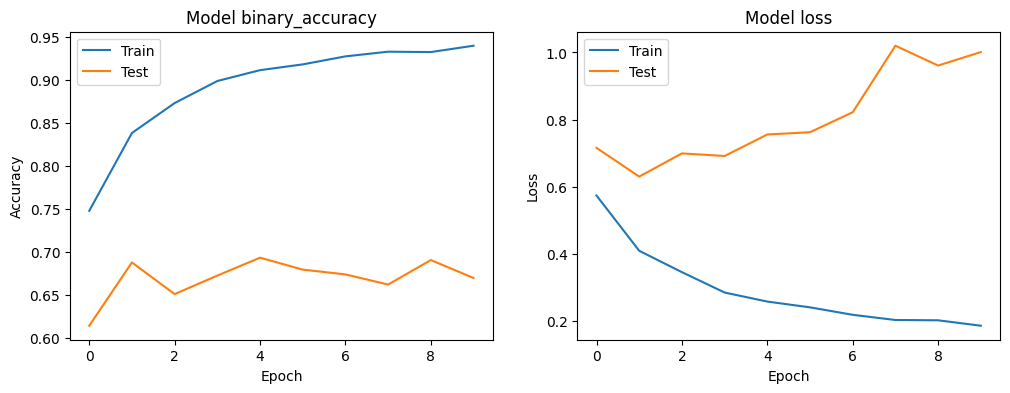

In [18]:
from keras.callbacks import EarlyStopping

# Build the model with the optimal hyperparameters
best_model = build_model()

# Compile the model with the optimal learning rate
best_model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy()])

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = best_model.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],  # Add early_stopping to callbacks
    verbose=2
)

# Function to plot training curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model binary_accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Plot the training curves
plot_training_curves(history)


In [19]:
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tqdm import tqdm

# Assuming best_model is loaded from the notebook
# best_model = load_model('final_model_0908_seq2seq_2.h5')

# Step 1: Initially train the model on x_train and y_train
# Assuming this has been done in the notebook

# Step 2: Online learning with x_test
y_preds = []
training_losses = []
training_acc = []
val_losses = []
val_acc = []
for i in tqdm(range(len(x_test))):
    # Predict the next instance
    y_pred = best_model.predict(x_test[i:i+1])
    y_preds.append(y_pred[0])
    
    # Add the instance and its actual result to the training dataset
    x_train = np.append(x_train, x_test[i:i+1], axis=0)
    y_train = np.append(y_train, y_test[i:i+1], axis=0)
    
    # Retrain the model on this updated dataset
    history_slide = best_model.fit(x_train, y_train, validation_data=(x_test[i:i+1], y_test[i:i+1]), epochs=1, verbose=2)
    training_losses.append(history_slide.history['loss'][0])
    training_acc.append(history_slide.history['binary_accuracy'][0])
    val_losses.append(history_slide.history['val_loss'][0])
    val_acc.append(history_slide.history['val_binary_accuracy'][0])

# Convert predictions to numpy array
y_preds = np.array(y_preds)

# Step 3: Evaluate the model
# Flatten the 3D tensors for evaluation
y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

# Calculate evaluation metrics
precision = precision_score(y_test_flat, y_preds_flat, average='macro')
recall = recall_score(y_test_flat, y_preds_flat, average='macro')
accuracy = accuracy_score(y_test_flat, y_preds_flat)
f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

precision, recall, accuracy, f1


  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 0s 361ms/step
108/108 - 3s - loss: 0.3038 - binary_accuracy: 0.8916 - val_loss: 0.3301 - val_binary_accuracy: 0.8750 - 3s/epoch - 24ms/step


  1%|          | 1/90 [00:03<04:41,  3.16s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.2719 - binary_accuracy: 0.9046 - val_loss: 0.1978 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


  2%|▏         | 2/90 [00:06<04:30,  3.07s/it]

1/1 [==============================] - 0s 31ms/step
108/108 - 3s - loss: 0.2419 - binary_accuracy: 0.9178 - val_loss: 1.1079 - val_binary_accuracy: 0.4375 - 3s/epoch - 26ms/step


  3%|▎         | 3/90 [00:09<04:22,  3.02s/it]

1/1 [==============================] - 0s 19ms/step
108/108 - 3s - loss: 0.2197 - binary_accuracy: 0.9269 - val_loss: 2.1099 - val_binary_accuracy: 0.3125 - 3s/epoch - 26ms/step


  4%|▍         | 4/90 [00:12<04:17,  3.00s/it]

1/1 [==============================] - 0s 18ms/step
108/108 - 3s - loss: 0.2064 - binary_accuracy: 0.9322 - val_loss: 0.7645 - val_binary_accuracy: 0.6875 - 3s/epoch - 27ms/step


  6%|▌         | 5/90 [00:15<04:15,  3.00s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1981 - binary_accuracy: 0.9337 - val_loss: 0.2061 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


  7%|▋         | 6/90 [00:18<04:13,  3.01s/it]

1/1 [==============================] - 0s 30ms/step
108/108 - 3s - loss: 0.1844 - binary_accuracy: 0.9412 - val_loss: 0.0942 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


  8%|▊         | 7/90 [00:21<04:11,  3.03s/it]

1/1 [==============================] - 0s 33ms/step
108/108 - 3s - loss: 0.1792 - binary_accuracy: 0.9421 - val_loss: 0.6252 - val_binary_accuracy: 0.6875 - 3s/epoch - 27ms/step


  9%|▉         | 8/90 [00:24<04:07,  3.02s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1596 - binary_accuracy: 0.9492 - val_loss: 0.0689 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


 10%|█         | 9/90 [00:27<04:06,  3.04s/it]

1/1 [==============================] - 0s 20ms/step
108/108 - 3s - loss: 0.1480 - binary_accuracy: 0.9523 - val_loss: 0.1858 - val_binary_accuracy: 0.8750 - 3s/epoch - 26ms/step


 11%|█         | 10/90 [00:30<04:01,  3.02s/it]

1/1 [==============================] - 0s 33ms/step
108/108 - 3s - loss: 0.1516 - binary_accuracy: 0.9501 - val_loss: 0.1968 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


 12%|█▏        | 11/90 [00:33<03:58,  3.02s/it]

1/1 [==============================] - 0s 22ms/step
108/108 - 3s - loss: 0.1538 - binary_accuracy: 0.9510 - val_loss: 0.0422 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


 13%|█▎        | 12/90 [00:36<03:55,  3.02s/it]

1/1 [==============================] - 0s 13ms/step
108/108 - 3s - loss: 0.1361 - binary_accuracy: 0.9576 - val_loss: 0.5440 - val_binary_accuracy: 0.7500 - 3s/epoch - 27ms/step


 14%|█▍        | 13/90 [00:39<03:52,  3.02s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1346 - binary_accuracy: 0.9577 - val_loss: 0.1872 - val_binary_accuracy: 0.9375 - 3s/epoch - 27ms/step


 16%|█▌        | 14/90 [00:42<03:50,  3.04s/it]

1/1 [==============================] - 0s 17ms/step
108/108 - 3s - loss: 0.1235 - binary_accuracy: 0.9617 - val_loss: 0.0333 - val_binary_accuracy: 1.0000 - 3s/epoch - 27ms/step


 17%|█▋        | 15/90 [00:45<03:48,  3.05s/it]

1/1 [==============================] - 0s 17ms/step
108/108 - 3s - loss: 0.1271 - binary_accuracy: 0.9600 - val_loss: 0.3183 - val_binary_accuracy: 0.8125 - 3s/epoch - 28ms/step


 18%|█▊        | 16/90 [00:48<03:46,  3.07s/it]

1/1 [==============================] - 0s 16ms/step
108/108 - 3s - loss: 0.1195 - binary_accuracy: 0.9624 - val_loss: 0.8141 - val_binary_accuracy: 0.8125 - 3s/epoch - 28ms/step


 19%|█▉        | 17/90 [00:51<03:44,  3.08s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1198 - binary_accuracy: 0.9629 - val_loss: 0.7444 - val_binary_accuracy: 0.5000 - 3s/epoch - 28ms/step


 20%|██        | 18/90 [00:54<03:43,  3.10s/it]

1/1 [==============================] - 0s 16ms/step
108/108 - 3s - loss: 0.1135 - binary_accuracy: 0.9652 - val_loss: 0.2827 - val_binary_accuracy: 0.8750 - 3s/epoch - 28ms/step


 21%|██        | 19/90 [00:58<03:41,  3.12s/it]

1/1 [==============================] - 0s 26ms/step
108/108 - 3s - loss: 0.1129 - binary_accuracy: 0.9654 - val_loss: 0.8674 - val_binary_accuracy: 0.6875 - 3s/epoch - 28ms/step


 22%|██▏       | 20/90 [01:01<03:39,  3.14s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1078 - binary_accuracy: 0.9662 - val_loss: 0.0328 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 23%|██▎       | 21/90 [01:04<03:37,  3.15s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.1004 - binary_accuracy: 0.9691 - val_loss: 0.1787 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 24%|██▍       | 22/90 [01:07<03:35,  3.17s/it]

1/1 [==============================] - 0s 29ms/step
108/108 - 3s - loss: 0.1021 - binary_accuracy: 0.9687 - val_loss: 0.1358 - val_binary_accuracy: 0.9375 - 3s/epoch - 28ms/step


 26%|██▌       | 23/90 [01:10<03:32,  3.17s/it]

1/1 [==============================] - 0s 33ms/step
108/108 - 3s - loss: 0.1016 - binary_accuracy: 0.9679 - val_loss: 0.4467 - val_binary_accuracy: 0.8125 - 3s/epoch - 28ms/step


 27%|██▋       | 24/90 [01:13<03:29,  3.17s/it]

1/1 [==============================] - 0s 15ms/step
108/108 - 3s - loss: 0.0978 - binary_accuracy: 0.9704 - val_loss: 0.3505 - val_binary_accuracy: 0.8125 - 3s/epoch - 28ms/step


 28%|██▊       | 25/90 [01:17<03:26,  3.17s/it]

1/1 [==============================] - 0s 17ms/step
108/108 - 3s - loss: 0.0922 - binary_accuracy: 0.9712 - val_loss: 0.1550 - val_binary_accuracy: 0.9375 - 3s/epoch - 28ms/step


 29%|██▉       | 26/90 [01:20<03:22,  3.17s/it]

1/1 [==============================] - 0s 14ms/step
109/109 - 3s - loss: 0.1080 - binary_accuracy: 0.9651 - val_loss: 0.0400 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 30%|███       | 27/90 [01:23<03:19,  3.17s/it]

1/1 [==============================] - 0s 10ms/step
109/109 - 3s - loss: 0.0932 - binary_accuracy: 0.9714 - val_loss: 0.0260 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 31%|███       | 28/90 [01:26<03:17,  3.19s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0921 - binary_accuracy: 0.9719 - val_loss: 0.2802 - val_binary_accuracy: 0.8750 - 3s/epoch - 28ms/step


 32%|███▏      | 29/90 [01:29<03:14,  3.19s/it]

1/1 [==============================] - 0s 15ms/step
109/109 - 3s - loss: 0.1461 - binary_accuracy: 0.9522 - val_loss: 0.1156 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 33%|███▎      | 30/90 [01:33<03:11,  3.20s/it]

1/1 [==============================] - 0s 32ms/step
109/109 - 3s - loss: 0.1042 - binary_accuracy: 0.9688 - val_loss: 0.5729 - val_binary_accuracy: 0.6875 - 3s/epoch - 28ms/step


 34%|███▍      | 31/90 [01:36<03:09,  3.21s/it]

1/1 [==============================] - 0s 18ms/step
109/109 - 3s - loss: 0.1009 - binary_accuracy: 0.9691 - val_loss: 1.0429 - val_binary_accuracy: 0.6250 - 3s/epoch - 28ms/step


 36%|███▌      | 32/90 [01:39<03:06,  3.22s/it]

1/1 [==============================] - 0s 16ms/step
109/109 - 3s - loss: 0.1118 - binary_accuracy: 0.9659 - val_loss: 0.0667 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 37%|███▋      | 33/90 [01:42<03:02,  3.21s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0907 - binary_accuracy: 0.9731 - val_loss: 0.0792 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 38%|███▊      | 34/90 [01:46<03:00,  3.23s/it]

1/1 [==============================] - 0s 29ms/step
109/109 - 3s - loss: 0.0904 - binary_accuracy: 0.9729 - val_loss: 0.2243 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 39%|███▉      | 35/90 [01:49<02:58,  3.24s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0833 - binary_accuracy: 0.9758 - val_loss: 0.7798 - val_binary_accuracy: 0.8125 - 3s/epoch - 29ms/step


 40%|████      | 36/90 [01:52<02:55,  3.24s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0791 - binary_accuracy: 0.9770 - val_loss: 0.1080 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 41%|████      | 37/90 [01:55<02:52,  3.26s/it]

1/1 [==============================] - 0s 18ms/step
109/109 - 3s - loss: 0.0780 - binary_accuracy: 0.9778 - val_loss: 0.2490 - val_binary_accuracy: 0.8750 - 3s/epoch - 28ms/step


 42%|████▏     | 38/90 [01:59<02:49,  3.25s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0742 - binary_accuracy: 0.9786 - val_loss: 0.0253 - val_binary_accuracy: 1.0000 - 3s/epoch - 30ms/step


 43%|████▎     | 39/90 [02:02<02:47,  3.28s/it]

1/1 [==============================] - 0s 32ms/step
109/109 - 3s - loss: 0.0776 - binary_accuracy: 0.9773 - val_loss: 0.0317 - val_binary_accuracy: 1.0000 - 3s/epoch - 31ms/step


 44%|████▍     | 40/90 [02:06<02:48,  3.37s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0742 - binary_accuracy: 0.9781 - val_loss: 0.0216 - val_binary_accuracy: 1.0000 - 3s/epoch - 31ms/step


 46%|████▌     | 41/90 [02:09<02:47,  3.42s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0696 - binary_accuracy: 0.9794 - val_loss: 0.0211 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 47%|████▋     | 42/90 [02:12<02:41,  3.36s/it]

1/1 [==============================] - 0s 29ms/step
109/109 - 3s - loss: 0.0725 - binary_accuracy: 0.9786 - val_loss: 0.0205 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 48%|████▊     | 43/90 [02:15<02:35,  3.31s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0706 - binary_accuracy: 0.9787 - val_loss: 0.0235 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 49%|████▉     | 44/90 [02:19<02:31,  3.28s/it]

1/1 [==============================] - 0s 30ms/step
109/109 - 3s - loss: 0.0668 - binary_accuracy: 0.9800 - val_loss: 2.1082 - val_binary_accuracy: 0.6250 - 3s/epoch - 28ms/step


 50%|█████     | 45/90 [02:22<02:26,  3.26s/it]

1/1 [==============================] - 0s 17ms/step
109/109 - 3s - loss: 0.0789 - binary_accuracy: 0.9757 - val_loss: 0.1210 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 51%|█████     | 46/90 [02:25<02:23,  3.26s/it]

1/1 [==============================] - 0s 15ms/step
109/109 - 3s - loss: 0.0826 - binary_accuracy: 0.9751 - val_loss: 0.8311 - val_binary_accuracy: 0.5000 - 3s/epoch - 29ms/step


 52%|█████▏    | 47/90 [02:28<02:20,  3.26s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0711 - binary_accuracy: 0.9787 - val_loss: 1.0005 - val_binary_accuracy: 0.6875 - 3s/epoch - 29ms/step


 53%|█████▎    | 48/90 [02:32<02:17,  3.27s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0689 - binary_accuracy: 0.9792 - val_loss: 0.0764 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 54%|█████▍    | 49/90 [02:35<02:14,  3.28s/it]

1/1 [==============================] - 0s 18ms/step
109/109 - 3s - loss: 0.0681 - binary_accuracy: 0.9796 - val_loss: 0.0608 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 56%|█████▌    | 50/90 [02:38<02:10,  3.27s/it]

1/1 [==============================] - 0s 15ms/step
109/109 - 3s - loss: 0.0763 - binary_accuracy: 0.9773 - val_loss: 1.9028 - val_binary_accuracy: 0.5000 - 3s/epoch - 29ms/step


 57%|█████▋    | 51/90 [02:42<02:07,  3.27s/it]

1/1 [==============================] - 0s 15ms/step
109/109 - 3s - loss: 0.0859 - binary_accuracy: 0.9737 - val_loss: 0.0294 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 58%|█████▊    | 52/90 [02:45<02:03,  3.26s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0697 - binary_accuracy: 0.9800 - val_loss: 0.0461 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 59%|█████▉    | 53/90 [02:48<02:00,  3.26s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0704 - binary_accuracy: 0.9790 - val_loss: 0.0968 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 60%|██████    | 54/90 [02:51<01:57,  3.27s/it]

1/1 [==============================] - 0s 18ms/step
109/109 - 3s - loss: 0.0653 - binary_accuracy: 0.9809 - val_loss: 0.6439 - val_binary_accuracy: 0.8125 - 3s/epoch - 29ms/step


 61%|██████    | 55/90 [02:55<01:55,  3.29s/it]

1/1 [==============================] - 0s 15ms/step
109/109 - 3s - loss: 0.0627 - binary_accuracy: 0.9813 - val_loss: 0.5781 - val_binary_accuracy: 0.8125 - 3s/epoch - 29ms/step


 62%|██████▏   | 56/90 [02:58<01:51,  3.29s/it]

1/1 [==============================] - 0s 18ms/step
109/109 - 3s - loss: 0.0632 - binary_accuracy: 0.9812 - val_loss: 0.1550 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 63%|██████▎   | 57/90 [03:01<01:48,  3.30s/it]

1/1 [==============================] - 0s 33ms/step
109/109 - 3s - loss: 0.0668 - binary_accuracy: 0.9800 - val_loss: 1.7221 - val_binary_accuracy: 0.6875 - 3s/epoch - 29ms/step


 64%|██████▍   | 58/90 [03:05<01:45,  3.29s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0676 - binary_accuracy: 0.9798 - val_loss: 0.3754 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 66%|██████▌   | 59/90 [03:08<01:41,  3.29s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0760 - binary_accuracy: 0.9770 - val_loss: 0.2813 - val_binary_accuracy: 0.8750 - 3s/epoch - 29ms/step


 67%|██████▋   | 60/90 [03:11<01:38,  3.30s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0912 - binary_accuracy: 0.9713 - val_loss: 0.0231 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 68%|██████▊   | 61/90 [03:14<01:35,  3.30s/it]

1/1 [==============================] - 0s 18ms/step
110/110 - 3s - loss: 0.0973 - binary_accuracy: 0.9708 - val_loss: 0.1272 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 69%|██████▉   | 62/90 [03:18<01:31,  3.28s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0658 - binary_accuracy: 0.9818 - val_loss: 0.0246 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 70%|███████   | 63/90 [03:21<01:28,  3.28s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0651 - binary_accuracy: 0.9821 - val_loss: 0.7043 - val_binary_accuracy: 0.8750 - 3s/epoch - 28ms/step


 71%|███████   | 64/90 [03:24<01:25,  3.28s/it]

1/1 [==============================] - 0s 32ms/step
110/110 - 3s - loss: 0.1055 - binary_accuracy: 0.9678 - val_loss: 5.3478 - val_binary_accuracy: 0.0000e+00 - 3s/epoch - 28ms/step


 72%|███████▏  | 65/90 [03:27<01:21,  3.27s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0697 - binary_accuracy: 0.9814 - val_loss: 1.1723 - val_binary_accuracy: 0.1250 - 3s/epoch - 28ms/step


 73%|███████▎  | 66/90 [03:31<01:18,  3.27s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0614 - binary_accuracy: 0.9837 - val_loss: 0.0215 - val_binary_accuracy: 1.0000 - 3s/epoch - 28ms/step


 74%|███████▍  | 67/90 [03:34<01:15,  3.26s/it]

1/1 [==============================] - 0s 17ms/step
110/110 - 3s - loss: 0.0609 - binary_accuracy: 0.9834 - val_loss: 1.4597 - val_binary_accuracy: 0.5000 - 3s/epoch - 29ms/step


 76%|███████▌  | 68/90 [03:37<01:11,  3.27s/it]

1/1 [==============================] - 0s 29ms/step
110/110 - 3s - loss: 0.0580 - binary_accuracy: 0.9841 - val_loss: 0.6150 - val_binary_accuracy: 0.6875 - 3s/epoch - 28ms/step


 77%|███████▋  | 69/90 [03:41<01:08,  3.27s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0643 - binary_accuracy: 0.9814 - val_loss: 0.0267 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 78%|███████▊  | 70/90 [03:44<01:05,  3.29s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0568 - binary_accuracy: 0.9848 - val_loss: 0.3904 - val_binary_accuracy: 0.8750 - 3s/epoch - 29ms/step


 79%|███████▉  | 71/90 [03:47<01:02,  3.30s/it]

1/1 [==============================] - 0s 18ms/step
110/110 - 3s - loss: 0.0620 - binary_accuracy: 0.9817 - val_loss: 0.2082 - val_binary_accuracy: 0.8750 - 3s/epoch - 29ms/step


 80%|████████  | 72/90 [03:50<00:59,  3.30s/it]

1/1 [==============================] - 0s 27ms/step
110/110 - 3s - loss: 0.0551 - binary_accuracy: 0.9845 - val_loss: 0.0232 - val_binary_accuracy: 1.0000 - 3s/epoch - 30ms/step


 81%|████████  | 73/90 [03:54<00:56,  3.33s/it]

1/1 [==============================] - 0s 32ms/step
110/110 - 3s - loss: 0.0622 - binary_accuracy: 0.9824 - val_loss: 0.0202 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 82%|████████▏ | 74/90 [03:57<00:53,  3.33s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0582 - binary_accuracy: 0.9833 - val_loss: 0.3948 - val_binary_accuracy: 0.8750 - 3s/epoch - 29ms/step


 83%|████████▎ | 75/90 [04:01<00:49,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0514 - binary_accuracy: 0.9858 - val_loss: 0.0452 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 84%|████████▍ | 76/90 [04:04<00:46,  3.33s/it]

1/1 [==============================] - 0s 29ms/step
110/110 - 3s - loss: 0.0496 - binary_accuracy: 0.9864 - val_loss: 1.5199 - val_binary_accuracy: 0.1875 - 3s/epoch - 29ms/step


 86%|████████▌ | 77/90 [04:07<00:43,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0630 - binary_accuracy: 0.9810 - val_loss: 1.5034 - val_binary_accuracy: 0.6875 - 3s/epoch - 29ms/step


 87%|████████▋ | 78/90 [04:11<00:39,  3.33s/it]

1/1 [==============================] - 0s 17ms/step
110/110 - 3s - loss: 0.0595 - binary_accuracy: 0.9823 - val_loss: 0.1023 - val_binary_accuracy: 0.9375 - 3s/epoch - 29ms/step


 88%|████████▊ | 79/90 [04:14<00:36,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0704 - binary_accuracy: 0.9790 - val_loss: 2.8037 - val_binary_accuracy: 0.3125 - 3s/epoch - 29ms/step


 89%|████████▉ | 80/90 [04:17<00:33,  3.33s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0620 - binary_accuracy: 0.9824 - val_loss: 0.5259 - val_binary_accuracy: 0.8125 - 3s/epoch - 29ms/step


 90%|█████████ | 81/90 [04:21<00:30,  3.34s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0607 - binary_accuracy: 0.9822 - val_loss: 0.0762 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 91%|█████████ | 82/90 [04:24<00:26,  3.34s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0655 - binary_accuracy: 0.9812 - val_loss: 2.1517 - val_binary_accuracy: 0.2500 - 3s/epoch - 29ms/step


 92%|█████████▏| 83/90 [04:27<00:23,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0793 - binary_accuracy: 0.9774 - val_loss: 0.0199 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 93%|█████████▎| 84/90 [04:31<00:19,  3.33s/it]

1/1 [==============================] - 0s 17ms/step
110/110 - 3s - loss: 0.0545 - binary_accuracy: 0.9856 - val_loss: 0.0196 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 94%|█████████▍| 85/90 [04:34<00:16,  3.33s/it]

1/1 [==============================] - 0s 17ms/step
110/110 - 3s - loss: 0.0557 - binary_accuracy: 0.9847 - val_loss: 1.3733 - val_binary_accuracy: 0.6875 - 3s/epoch - 29ms/step


 96%|█████████▌| 86/90 [04:37<00:13,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0563 - binary_accuracy: 0.9843 - val_loss: 0.1472 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 97%|█████████▋| 87/90 [04:41<00:10,  3.34s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0526 - binary_accuracy: 0.9851 - val_loss: 2.3537 - val_binary_accuracy: 0.2500 - 3s/epoch - 29ms/step


 98%|█████████▊| 88/90 [04:44<00:06,  3.33s/it]

1/1 [==============================] - 0s 33ms/step
110/110 - 3s - loss: 0.0515 - binary_accuracy: 0.9860 - val_loss: 0.0362 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


 99%|█████████▉| 89/90 [04:47<00:03,  3.35s/it]

1/1 [==============================] - 0s 15ms/step
110/110 - 3s - loss: 0.0526 - binary_accuracy: 0.9855 - val_loss: 0.0159 - val_binary_accuracy: 1.0000 - 3s/epoch - 29ms/step


100%|██████████| 90/90 [04:51<00:00,  3.23s/it]


(0.6116192709278694,
 0.5861441798941799,
 0.6909722222222222,
 0.5898551884150731)

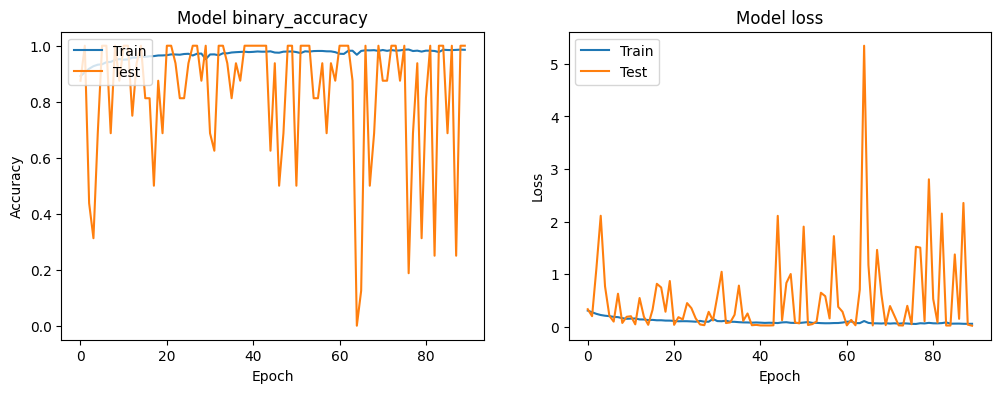

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_acc)
plt.plot(val_acc)
plt.title('Model binary_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_losses)
plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# 初始化指標
total_precision = 0
total_recall = 0
total_accuracy = 0
total_f1 = 0
num_steps = y_test.shape[1]

# 針對每個時間步計算指標
for step in range(num_steps):
    y_true_step = np.argmax(y_test[:, step, :], axis=1)
    y_pred_step = np.argmax(y_preds[:, step, :], axis=1)
    
    total_precision += precision_score(y_true_step, y_pred_step, average='macro')
    total_recall += recall_score(y_true_step, y_pred_step, average='macro')
    total_accuracy += accuracy_score(y_true_step, y_pred_step)
    total_f1 += f1_score(y_true_step, y_pred_step, average='macro')

# 取平均值
avg_precision = total_precision / num_steps
avg_recall = total_recall / num_steps
avg_accuracy = total_accuracy / num_steps
avg_f1 = total_f1 / num_steps

# 顯示結果
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1}')


Average Precision: 0.6222733591785848
Average Recall: 0.5853226867331284
Average Accuracy: 0.6909722222222222
Average F1 Score: 0.5906989805116196


In [22]:
# Step 1: Find the index of the maximum value along the last dimension
max_indices = np.argmax(y_preds, axis=-1)

# Step 2: Create an array of zeros with the same shape as y_preds
y_pred_modified = np.zeros_like(y_preds)

# Step 3: Set the maximum value positions to 1
for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        max_index = max_indices[i, j]
        y_pred_modified[i, j, max_index] = 1
# Reverse one-hot encoding and flatten
flatten_y_test = np.argmax(y_test, axis=-1).flatten()  
flatten_y_pred = np.argmax(y_preds, axis=-1).flatten() 

# Identify indices where value changes from 1 to 0 and 0 to 1
y_test_indices_downward_to_upward  = [i for i in range(1, len(flatten_y_test)) if flatten_y_test[i-1] == 1 and flatten_y_test[i] == 0]
y_test_indices_upward_to_downward = [i for i in range(1, len(flatten_y_test)) if flatten_y_test[i-1] == 0 and flatten_y_test[i] == 1]

y_pred_indices_downward_to_upward  = [i for i in range(1, len(flatten_y_pred)) if flatten_y_pred[i-1] == 1 and flatten_y_pred[i] == 0]
y_pred_indices_upward_to_downward = [i for i in range(1, len(flatten_y_pred)) if flatten_y_pred[i-1] == 0 and flatten_y_pred[i] == 1]

diffs_downward_to_upward  = []
for pred_idx in y_pred_indices_downward_to_upward :
    # Calculate absolute differences with all values in y_test_indices_downward_to_upward 
    abs_diffs = [abs(test_idx - pred_idx) for test_idx in y_test_indices_downward_to_upward ]
    # Find the index of the minimum absolute difference
    closest_idx = np.argmin(abs_diffs)
    # Compute the actual difference
    actual_diff = y_test_indices_downward_to_upward [closest_idx] - pred_idx
    diffs_downward_to_upward .append(actual_diff)

diffs_upward_to_downward = []
for pred_idx in y_pred_indices_upward_to_downward:
    # Calculate absolute differences with all values in y_test_indices_upward_to_downward
    abs_diffs = [abs(test_idx - pred_idx) for test_idx in y_test_indices_upward_to_downward]
    # Find the index of the minimum absolute difference
    closest_idx = np.argmin(abs_diffs)
    # Compute the actual difference
    actual_diff = y_test_indices_upward_to_downward[closest_idx] - pred_idx
    diffs_upward_to_downward.append(actual_diff)

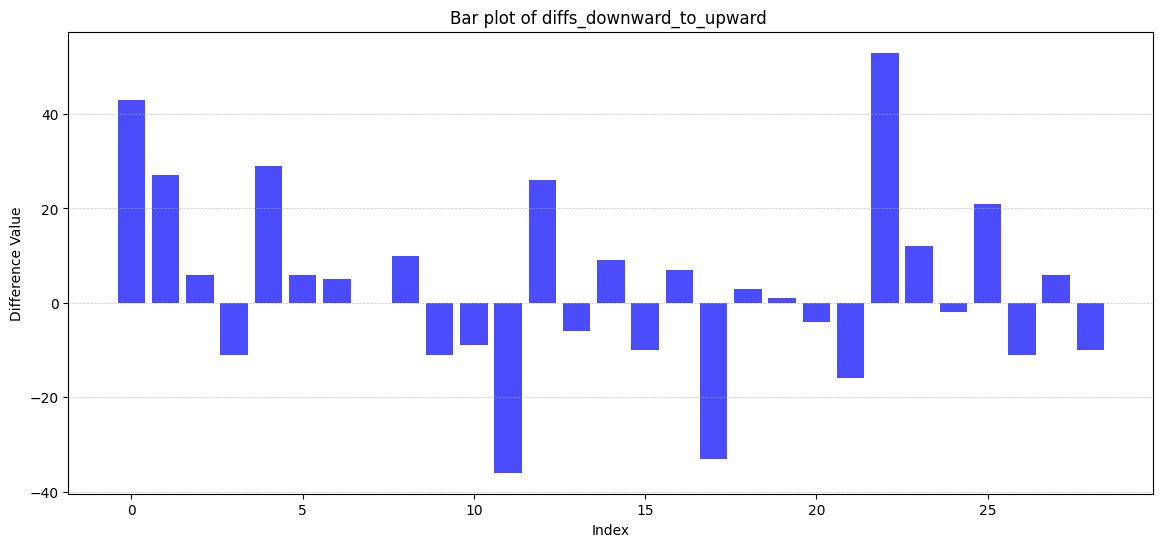

In [23]:
# Create bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(diffs_downward_to_upward )), diffs_downward_to_upward , color='blue', alpha=0.7)
plt.title('Bar plot of diffs_downward_to_upward ')
plt.xlabel('Index')
plt.ylabel('Difference Value')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [24]:
bias_diffs_downward_to_upward  = np.mean(np.abs(diffs_downward_to_upward ))
variance_diffs_downward_to_upward  = np.mean((diffs_downward_to_upward  - bias_diffs_downward_to_upward ) ** 2)

bias_diffs_downward_to_upward , variance_diffs_downward_to_upward 

(14.586206896551724, 493.44351961950065)

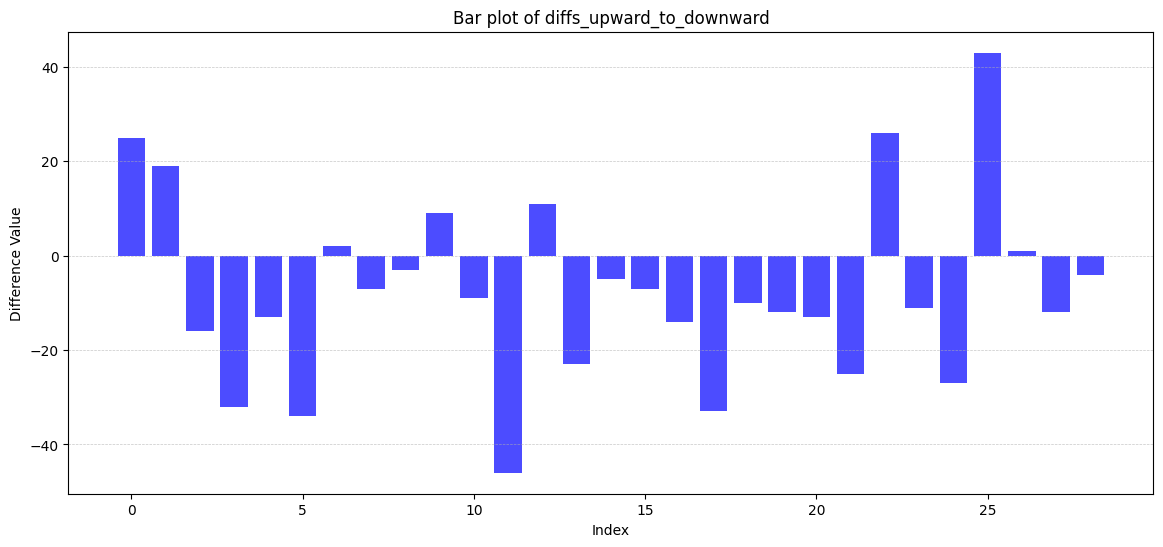

In [25]:
# Create bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(diffs_upward_to_downward)), diffs_upward_to_downward, color='blue', alpha=0.7)
plt.title('Bar plot of diffs_upward_to_downward')
plt.xlabel('Index')
plt.ylabel('Difference Value')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [26]:
bias_diffs_upward_to_downward = np.mean(np.abs(diffs_upward_to_downward))
variance_diffs_upward_to_downward = np.mean((diffs_upward_to_downward - bias_diffs_upward_to_downward) ** 2)

bias_diffs_upward_to_downward, variance_diffs_upward_to_downward

(16.96551724137931, 976.7538644470868)

In [27]:
# num_features = y_test_stock_data.shape[1]
# formatted_dates_series = pd.Series(y_test_date.flatten()).dt.strftime('%m-%d')
# formatted_dates_array = formatted_dates_series.values

# fig, ax = plt.subplots(len(feature_list) + 2, figsize=(20, 3 * (len(feature_list) + 2)))

# for feature in range(y_test_stock_data.shape[-1]):
#     ax[feature].plot(y_test_date.flatten(), y_test_stock_data[:, feature], marker='o')
#     ax[feature].set_title(f'{feature_list[feature]}')
#     ax[feature].set_xticks(y_test_date.flatten())  # Use the original datetime values for ticks
#     ax[feature].set_xticklabels(formatted_dates_array, rotation=45)  # Use formatted labels

# # This is just for demonstration purposes, as y_test_compare and y_pred_modified are not defined
# # Uncomment and modify as per your actual data
# ax[-2].plot(y_test_date.flatten(), flatten_y_pred, label=f'Actual Trend', marker='o')
# ax[-1].plot(y_test_date.flatten(), flatten_y_pred, label=f'Predicted Trend', marker='x')
# ax[-2].set_title('y_test')
# ax[-1].set_title('y_preds')
# ax[-2].legend()
# ax[-1].legend()

# plt.tight_layout()
# plt.show()


In [28]:
y_test_stock_data = y_test_stock_data.reshape([y_test_stock_data.shape[0]*y_test_stock_data.shape[1], y_test_stock_data.shape[2]])

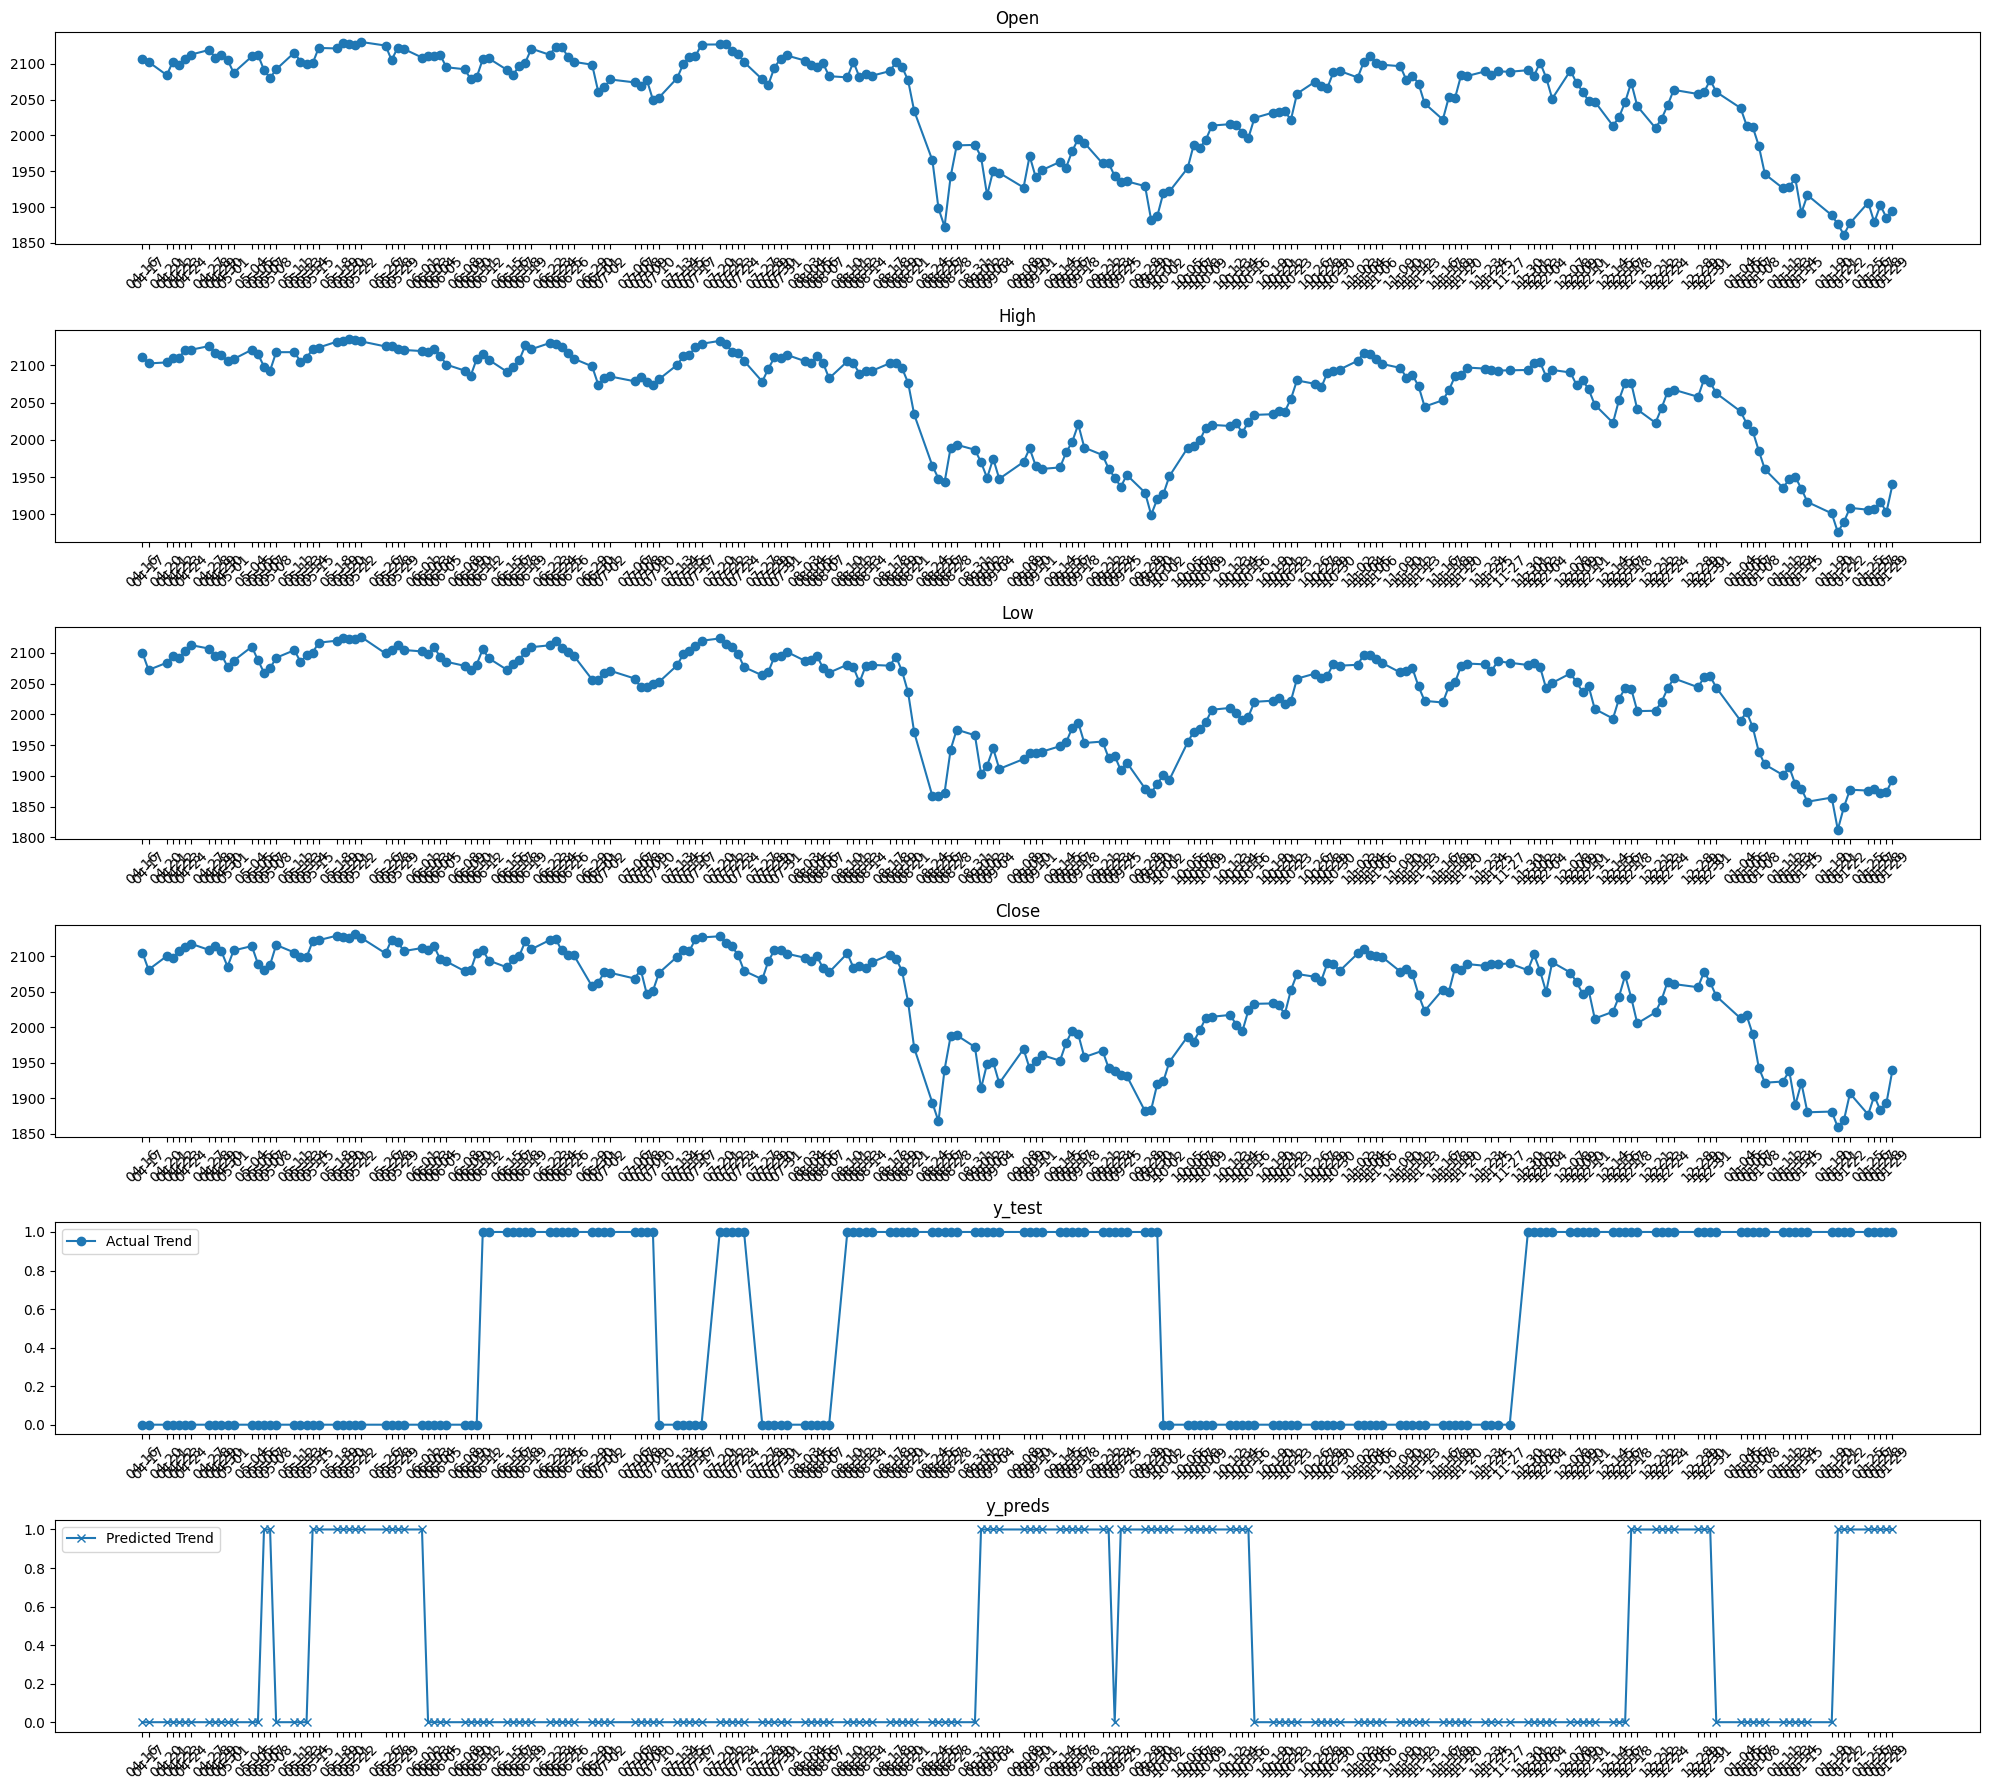

In [29]:
x_strat = 0
x_stop = 200
formatted_dates_series = pd.Series(y_test_date.flatten()[x_strat:x_stop]).dt.strftime('%m-%d')
formatted_dates_array = formatted_dates_series.values

fig, ax = plt.subplots(6, figsize=(20, 18))

for feature in range(4):
    ax[feature].plot(y_test_date.flatten()[x_strat:x_stop], y_test_stock_data[x_strat:x_stop,  feature], marker='o')
    ax[feature].set_title(f'{feature_list[feature]}')
for feature in range(6):
    ax[feature].set_xticks(y_test_date.flatten()[x_strat:x_stop])  # Use the original datetime values for ticks
    ax[feature].set_xticklabels(formatted_dates_array, rotation=45)  # Use formatted labels

# This is just for demonstration purposes, as y_test_compare and y_pred_modified are not defined
# Uncomment and modify as per your actual data
ax[-2].plot(y_test_date.flatten()[x_strat:x_stop], flatten_y_test[x_strat:x_stop], label=f'Actual Trend', marker='o')
ax[-1].plot(y_test_date.flatten()[x_strat:x_stop], flatten_y_pred[x_strat:x_stop], label=f'Predicted Trend', marker='x')
ax[-2].set_title('y_test')
ax[-1].set_title('y_preds')
ax[-2].legend()
ax[-1].legend()

plt.tight_layout()
plt.show()


In [30]:
import matplotlib.dates as mdates

def _kbar(open, close, high, low, pos, ax):
    if close > open:             # 上漲
        color='green'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='red'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    ax.bar(pos, height=height,bottom=bottom, width=0.6, color=color)
    # 繪製 k 棒上下影線
    ax.vlines(pos, high, low, color=color)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


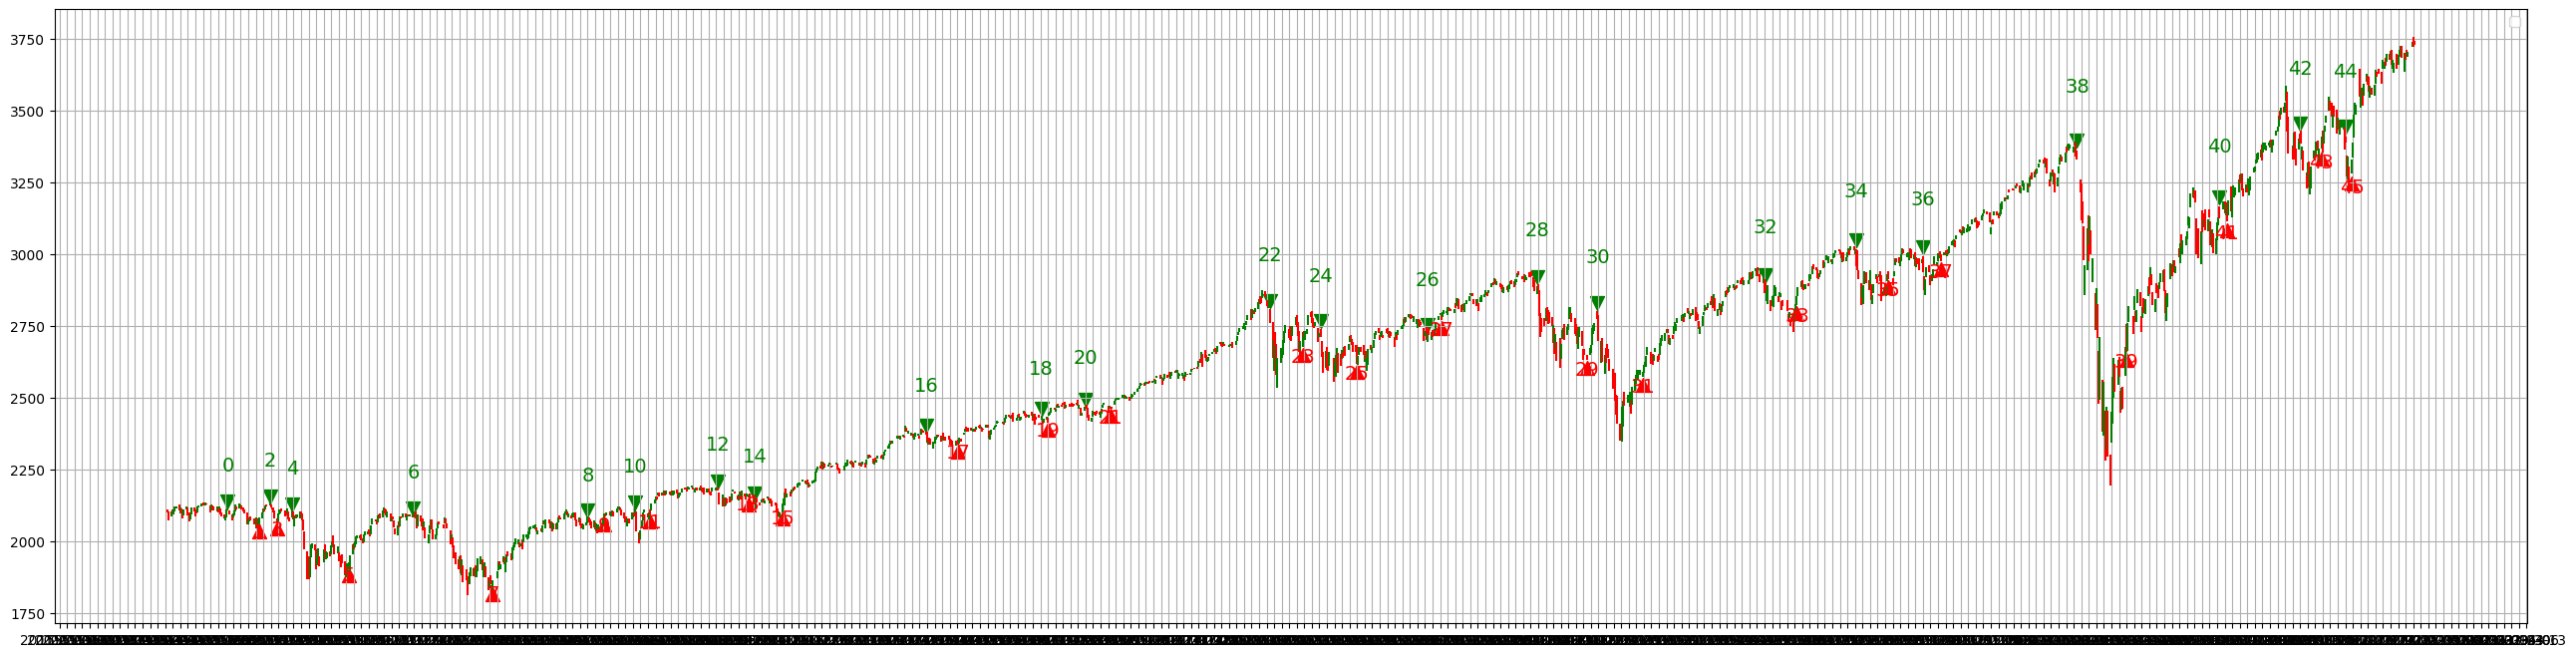

In [31]:
x_strat = 0
x_stop = -1
fig, ax = plt.subplots(figsize=(32, 8))

# Plotting the K-bar chart
for i in y_test_date.flatten()[x_strat:x_stop]:
    _kbar(stock_data['Open'].loc[i], stock_data['Close'].loc[i], stock_data['High'].loc[i], stock_data['Low'].loc[i], i, ax)

order = 0
for idx in sorted(y_test_indices_downward_to_upward + y_test_indices_upward_to_downward):
    if idx in y_test_indices_downward_to_upward:
        x_value = y_test_date.flatten()[idx]
        y_value = stock_data['Low'].loc[y_test_date.flatten()[idx]] *0.99
        ax.scatter(x_value, y_value, color='red', marker='^', s=100)
        ax.annotate(str(order), (x_value, y_value*0.99), color='red', fontsize=14, ha='center')

    elif idx in y_test_indices_upward_to_downward:
        x_value = y_test_date.flatten()[idx]
        y_value = stock_data['High'].loc[y_test_date.flatten()[idx]] *1.01
        ax.scatter(x_value, y_value, color='green', marker='v', s=100)
        ax.annotate(str(order), (x_value, y_value*1.05), color='green', fontsize=14, ha='center')
    order += 1

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.grid()
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


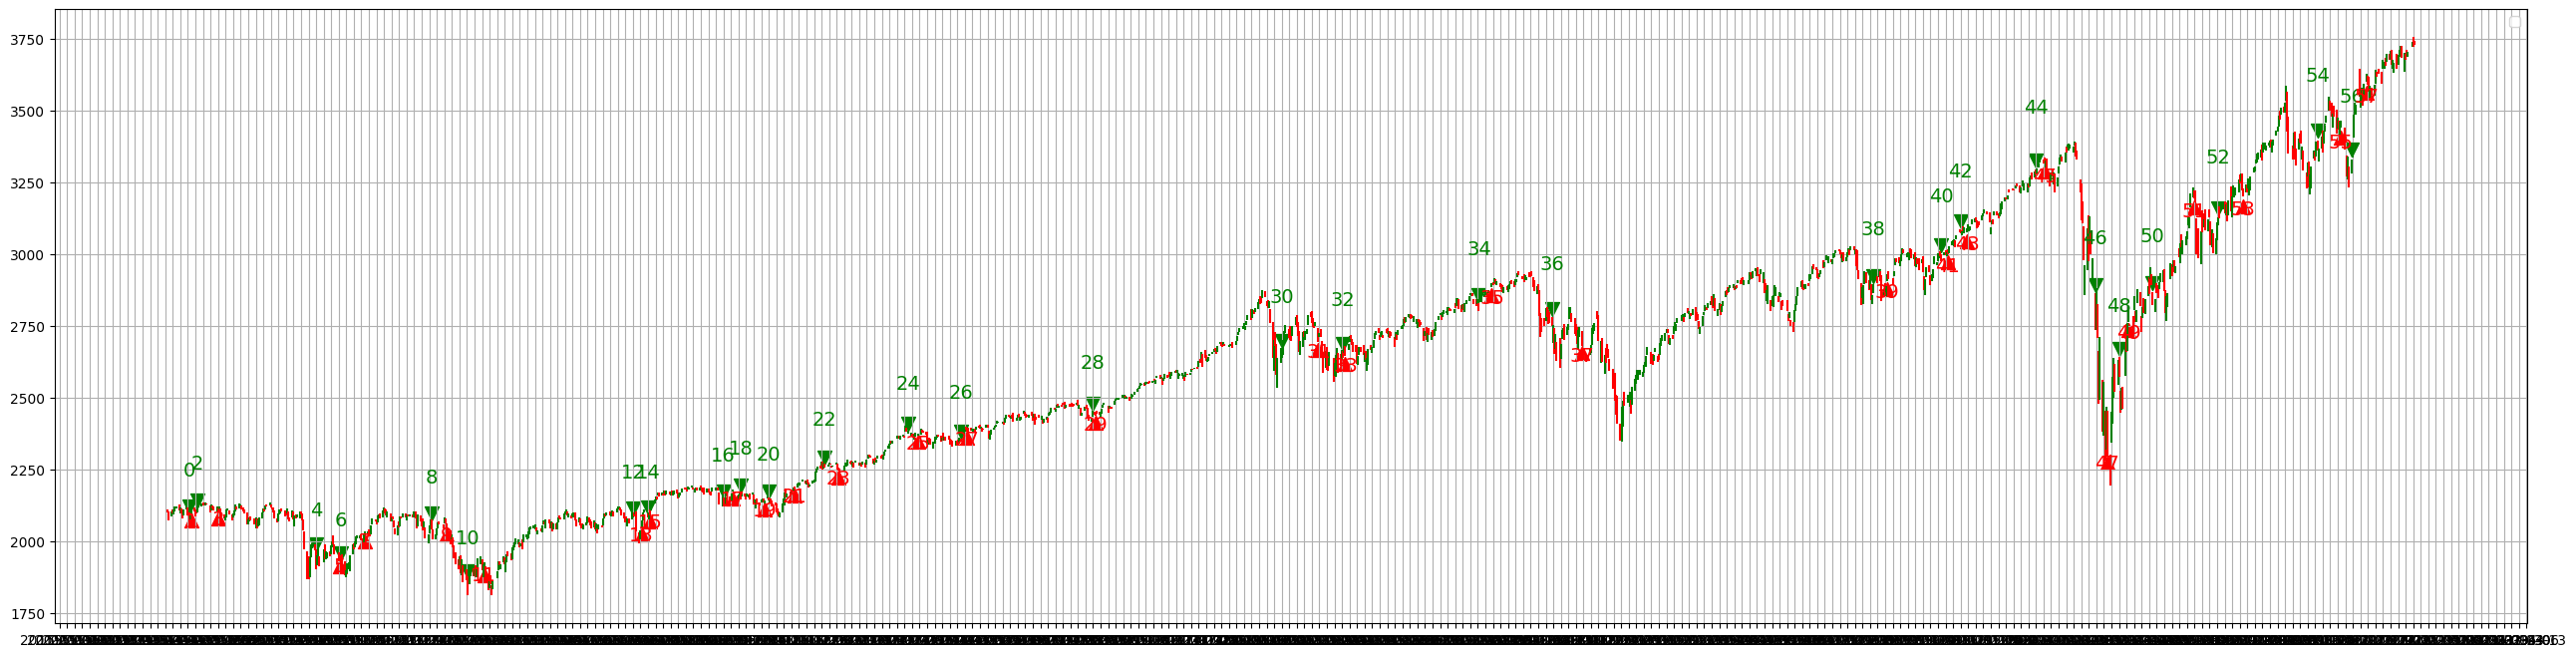

In [32]:
x_strat = 0
x_stop = -1
fig, ax = plt.subplots(figsize=(32, 8))

# Plotting the K-bar chart
for i in y_test_date.flatten()[x_strat:x_stop]:
    _kbar(stock_data['Open'].loc[i], stock_data['Close'].loc[i], stock_data['High'].loc[i], stock_data['Low'].loc[i], i, ax)

order = 0
for idx in sorted(y_pred_indices_downward_to_upward + y_pred_indices_upward_to_downward):
    if idx in y_pred_indices_downward_to_upward:
        x_value = y_test_date.flatten()[idx]
        y_value = stock_data['Low'].loc[y_test_date.flatten()[idx]] *0.99
        ax.scatter(x_value, y_value, color='red', marker='^', s=100)
        ax.annotate(str(order), (x_value, y_value*0.99), color='red', fontsize=14, ha='center')

    elif idx in y_pred_indices_upward_to_downward:
        x_value = y_test_date.flatten()[idx]
        y_value = stock_data['High'].loc[y_test_date.flatten()[idx]]*1.01
        ax.scatter(x_value, y_value, color='green', marker='v', s=100)
        ax.annotate(str(order), (x_value, y_value*1.05), color='green', fontsize=14, ha='center')
    order += 1

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.grid()
plt.legend()
plt.show()


In [33]:
# Reinitialize the transactions list and other variables
transactions = []
total_profit = 0
buy_price = 0
sell_price = 0
num_shares = 0  
y_test_idx_sorted = sorted(y_test_indices_downward_to_upward + y_test_indices_upward_to_downward)
# Iterate over indices
for idx in y_test_idx_sorted:
    if idx in y_test_indices_downward_to_upward:
        buy_price = stock_data['Close'].loc[y_test_date.flatten()[idx]]
        profit = -(num_shares) * (buy_price - sell_price)
        total_profit += profit
        profit_buy_and_hold = buy_price - stock_data['Close'].loc[y_test_date.flatten()[0]]
        transactions.append({
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Long',
            'Price': buy_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'profit_buy_and_hold': profit_buy_and_hold
        })
        num_shares = 1
        
    elif idx in y_test_indices_upward_to_downward:
        sell_price = stock_data['Close'].loc[y_test_date.flatten()[idx]]
        profit = (num_shares) * (sell_price - buy_price)
        total_profit += profit
        profit_buy_and_hold = sell_price - stock_data['Close'].loc[y_test_date.flatten()[0]]
        transactions.append({
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Short',
            'Price': sell_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'profit_buy_and_hold': profit_buy_and_hold
        })
        num_shares = 1

# Convert transactions list to DataFrame
profits_test = pd.DataFrame(transactions)

print(f'total_profit: {total_profit}')
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3):
    display(profits_test)


total_profit: 4925.118896484375


,Transaction Date,Action,Price,Shares,Profit,total_profit,profit_buy_and_hold
0,2015-06-11,Short,2108.86,0,0.00,0.000,3.87
1,2015-07-10,Long,2076.62,1,32.24,32.240,-28.37
2,2015-07-20,Short,2128.28,1,51.66,83.900,23.29
3,2015-07-27,Long,2067.64,1,60.64,144.540,-37.35
4,2015-08-10,Short,2104.18,1,36.54,181.080,-0.81
5,2015-10-01,Long,1923.82,1,180.36,361.440,-181.17
6,2015-11-30,Short,2080.41,1,156.59,518.030,-24.58
7,2016-02-12,Long,1864.78,1,215.63,733.660,-240.21
8,2016-05-10,Short,2084.39,1,219.61,953.270,-20.60
9,2016-05-25,Long,2090.54,1,-6.15,947.120,-14.45


In [34]:
# Modified code to include the diffs in the transactions
transactions = []
total_profit = 0
buy_price = 0
sell_price = 0
num_shares = 0 

downward_to_upward_counter = 0
upward_to_downward_counter = 0

for idx in sorted(y_pred_indices_downward_to_upward + y_pred_indices_upward_to_downward):
    transaction = {}
    
    if idx in y_pred_indices_downward_to_upward:
        buy_price = stock_data['Close'].loc[y_test_date.flatten()[idx]]
        profit = -(num_shares) * (buy_price - sell_price)
        total_profit += profit
        profit_buy_and_hold = buy_price - stock_data['Close'].loc[y_test_date.flatten()[0]]
        transaction = {
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Long',
            'Price': buy_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'Diff': diffs_downward_to_upward[downward_to_upward_counter],
            'profit_buy_and_hold': profit_buy_and_hold

        }
        downward_to_upward_counter += 1
        num_shares = 1
        
    elif idx in y_pred_indices_upward_to_downward:
        sell_price = stock_data['Close'].loc[y_test_date.flatten()[idx]]
        profit = (num_shares) * (sell_price - buy_price)
        total_profit += profit
        profit_buy_and_hold = sell_price - stock_data['Close'].loc[y_test_date.flatten()[0]]
        transaction = {
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Short',
            'Price': sell_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'Diff': diffs_upward_to_downward[upward_to_downward_counter],
            'profit_buy_and_hold': profit_buy_and_hold
        }
        upward_to_downward_counter += 1
        num_shares = 1

    transactions.append(transaction)

# Convert transactions list to DataFrame
profits_pred = pd.DataFrame(transactions)

print(f'total_profit: {total_profit}')
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3):
    display(profits_pred)


total_profit: -685.259033203125


,Transaction Date,Action,Price,Shares,Profit,total_profit,Diff,profit_buy_and_hold
0,2015-05-06,Short,2080.15,0,0.00,0.000,25,-24.84
1,2015-05-08,Long,2116.10,1,-35.95,-35.950,43,11.11
2,2015-05-14,Short,2121.10,1,5.00,-30.950,19,16.11
3,2015-06-02,Long,2109.60,1,11.50,-19.450,27,4.61
4,2015-09-01,Short,1913.85,1,-195.75,-215.200,-16,-191.14
5,2015-09-23,Long,1938.76,1,-24.91,-240.110,6,-166.23
6,2015-09-24,Short,1932.24,1,-6.52,-246.630,-32,-172.75
7,2015-10-16,Long,2033.11,1,-100.87,-347.500,-11,-71.88
8,2015-12-17,Short,2041.89,1,8.78,-338.720,-13,-63.10
9,2015-12-31,Long,2043.94,1,-2.05,-340.770,29,-61.05


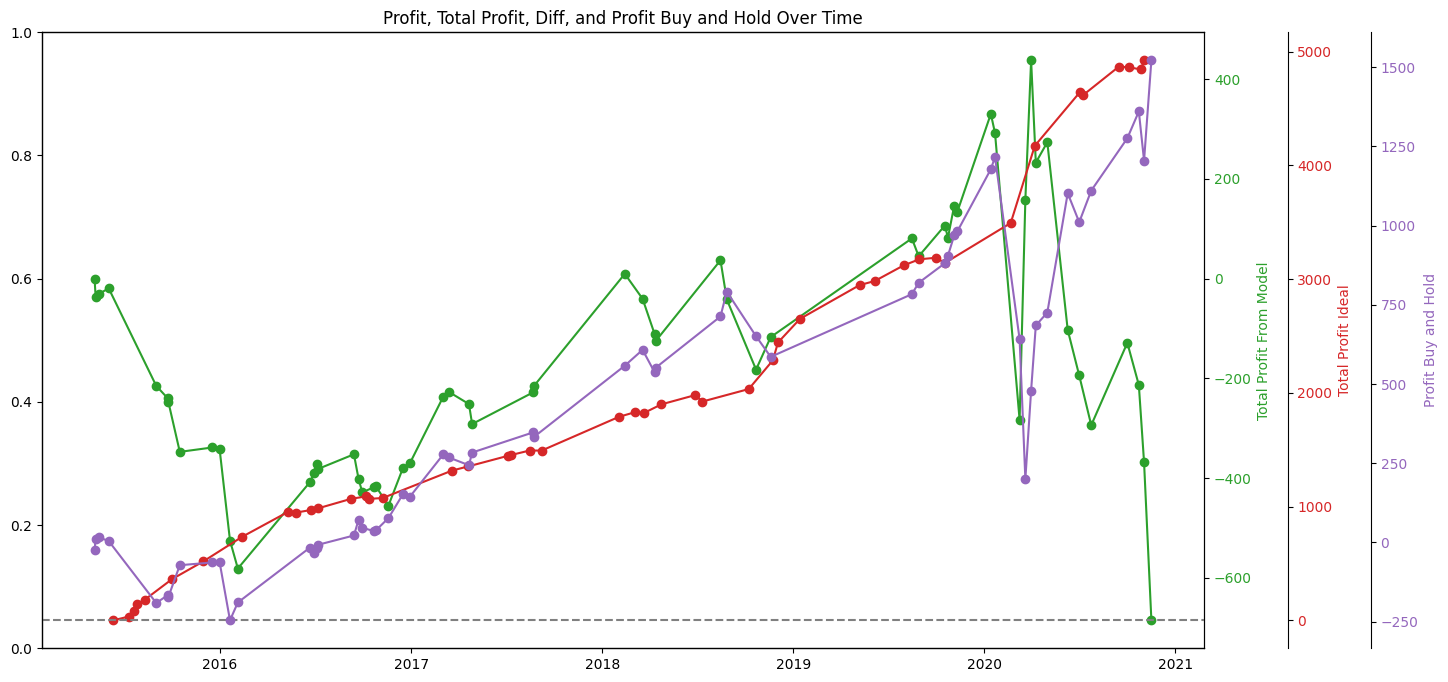

In [35]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# # Plot profit against Transaction Date with markers
# ax1.set_xlabel('Transaction Date')
# ax1.set_ylabel('Profit', color='tab:blue')
# ax1.plot(profits_pred['Transaction Date'], profits_pred['Profit'], color='tab:blue', label='Profit', marker='o')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot total_profit with markers
ax2 = ax1.twinx()
ax2.set_ylabel('Total Profit From Model', color='tab:green')
ax2.plot(profits_pred['Transaction Date'], profits_pred['total_profit'], color='tab:green', label='Total Profit From Model', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Create a third y-axis to plot Diff with markers
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move third axis to the right by 60 points
ax3.set_ylabel('Total Profit Ideal', color='tab:red')
ax3.plot(profits_test['Transaction Date'], profits_test['total_profit'], color='tab:red', label='Total Profit Ideal', marker='o')
ax3.tick_params(axis='y', labelcolor='tab:red')
ax3.axhline(0, color='gray', linestyle='--')  # Adding horizontal line at y=0 for ax3

# Create a fourth y-axis to plot profit_buy_and_hold with markers
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Move fourth axis to the right by 120 points
ax4.set_ylabel('Profit Buy and Hold', color='tab:purple')
ax4.plot(profits_pred['Transaction Date'], profits_pred['profit_buy_and_hold'], color='tab:purple', label='Profit Buy and Hold', marker='o')
ax4.tick_params(axis='y', labelcolor='tab:purple')

# Show the plot
plt.title('Profit, Total Profit, Diff, and Profit Buy and Hold Over Time')
plt.show()


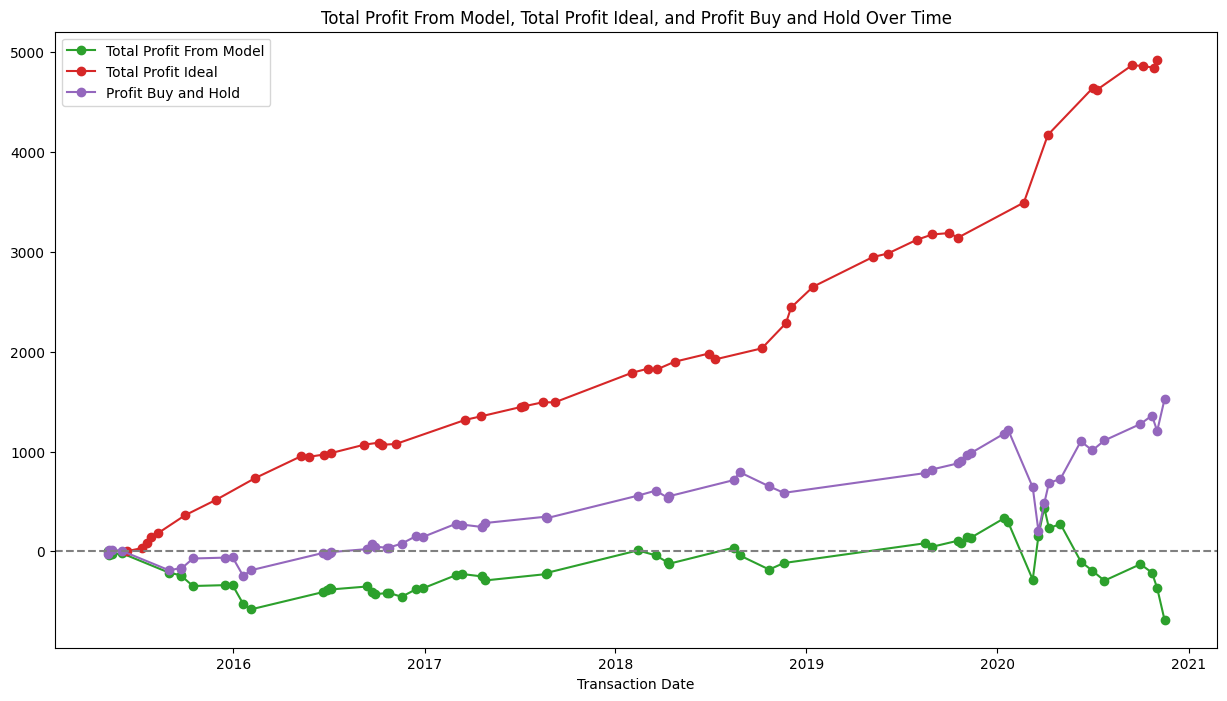

In [36]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel('Transaction Date')

# Plot total profit from the model
ax1.plot(profits_pred['Transaction Date'], profits_pred['total_profit'], color='tab:green', label='Total Profit From Model', marker='o')

# Plot total profit ideal
ax1.plot(profits_test['Transaction Date'], profits_test['total_profit'], color='tab:red', label='Total Profit Ideal', marker='o')

# Plot profit buy and hold
ax1.plot(profits_pred['Transaction Date'], profits_pred['profit_buy_and_hold'], color='tab:purple', label='Profit Buy and Hold', marker='o')

# Add legend to distinguish between the lines
ax1.legend(loc='upper left')

ax1.axhline(0, color='gray', linestyle='--')  # Adding horizontal line at y=0

# Show the plot
plt.title('Total Profit From Model, Total Profit Ideal, and Profit Buy and Hold Over Time')
plt.show()


In [37]:
# Reinitialize the transactions list and other variables
transactions = []
total_profit = 0
buy_price = 0
sell_price = 0
num_shares = 0  
y_test_idx_sorted = sorted(y_test_indices_downward_to_upward + y_test_indices_upward_to_downward)
# Iterate over indices
for idx in y_test_idx_sorted:
    if idx in y_test_indices_downward_to_upward:
        buy_price = stock_data['Low'].loc[y_test_date.flatten()[idx]]
        profit = -(num_shares) * (buy_price - sell_price)
        total_profit += profit
        profit_buy_and_hold = buy_price - stock_data['Low'].loc[y_test_date.flatten()[0]]
        transactions.append({
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Long',
            'Price': buy_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'profit_buy_and_hold': profit_buy_and_hold
        })
        num_shares = 1
        
    elif idx in y_test_indices_upward_to_downward:
        sell_price = stock_data['High'].loc[y_test_date.flatten()[idx]]
        profit = (num_shares) * (sell_price - buy_price)
        total_profit += profit
        profit_buy_and_hold = sell_price - stock_data['High'].loc[y_test_date.flatten()[0]]
        transactions.append({
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Short',
            'Price': sell_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'profit_buy_and_hold': profit_buy_and_hold
        })
        num_shares = 1

# Convert transactions list to DataFrame
profits_test = pd.DataFrame(transactions)

print(f'total_profit: {total_profit}')
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3):
    display(profits_test)


total_profit: 6382.39990234375


,Transaction Date,Action,Price,Shares,Profit,total_profit,profit_buy_and_hold
0,2015-06-11,Short,2115.02,0,0.00,0.000,3.72
1,2015-07-10,Long,2052.74,1,62.28,62.280,-47.28
2,2015-07-20,Short,2132.82,1,80.08,142.360,21.52
3,2015-07-27,Long,2063.52,1,69.30,211.660,-36.50
4,2015-08-10,Short,2105.35,1,41.83,253.490,-5.95
5,2015-10-01,Long,1900.70,1,204.65,458.140,-199.32
6,2015-11-30,Short,2093.81,1,193.11,651.250,-17.49
7,2016-02-12,Long,1833.40,1,260.41,911.661,-266.62
8,2016-05-10,Short,2084.87,1,251.47,1163.131,-26.43
9,2016-05-25,Long,2078.93,1,5.94,1169.071,-21.09


In [38]:
# Modified code to include the diffs in the transactions
transactions = []
total_profit = 0
buy_price = 0
sell_price = 0
num_shares = 0 

downward_to_upward_counter = 0
upward_to_downward_counter = 0

for idx in sorted(y_pred_indices_downward_to_upward + y_pred_indices_upward_to_downward):
    transaction = {}
    
    if idx in y_pred_indices_downward_to_upward:
        buy_price = stock_data['Low'].loc[y_test_date.flatten()[idx]]
        profit = -(num_shares) * (buy_price - sell_price)
        total_profit += profit
        profit_buy_and_hold = buy_price - stock_data['Low'].loc[y_test_date.flatten()[0]]
        transaction = {
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Long',
            'Price': buy_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'Diff': diffs_downward_to_upward[downward_to_upward_counter],
            'profit_buy_and_hold': profit_buy_and_hold

        }
        downward_to_upward_counter += 1
        num_shares = 1
        
    elif idx in y_pred_indices_upward_to_downward:
        sell_price = stock_data['High'].loc[y_test_date.flatten()[idx]]
        profit = (num_shares) * (sell_price - buy_price)
        total_profit += profit
        profit_buy_and_hold = sell_price - stock_data['High'].loc[y_test_date.flatten()[0]]
        transaction = {
            'Transaction Date': y_test_date.flatten()[idx],
            'Action': 'Short',
            'Price': sell_price,
            'Shares': num_shares,
            'Profit': profit,
            'total_profit': total_profit,
            'Diff': diffs_upward_to_downward[upward_to_downward_counter],
            'profit_buy_and_hold': profit_buy_and_hold
        }
        upward_to_downward_counter += 1
        num_shares = 1

    transactions.append(transaction)

# Convert transactions list to DataFrame
profits_pred = pd.DataFrame(transactions)

print(f'total_profit: {total_profit}')
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3):
    display(profits_pred)


total_profit: 1125.81884765625


,Transaction Date,Action,Price,Shares,Profit,total_profit,Diff,profit_buy_and_hold
0,2015-05-06,Short,2098.42,0,0.00,0.000,25,-12.88
1,2015-05-08,Long,2092.13,1,6.29,6.290,43,-7.89
2,2015-05-14,Short,2121.45,1,29.32,35.610,19,10.15
3,2015-06-02,Long,2099.14,1,22.31,57.920,27,-0.88
4,2015-09-01,Short,1970.09,1,-129.05,-71.130,-16,-141.21
5,2015-09-23,Long,1932.57,1,37.52,-33.610,6,-167.45
6,2015-09-24,Short,1937.17,1,4.60,-29.010,-32,-174.13
7,2015-10-16,Long,2020.46,1,-83.29,-112.300,-11,-79.56
8,2015-12-17,Short,2076.37,1,55.91,-56.389,-13,-34.93
9,2015-12-31,Long,2043.62,1,32.75,-23.639,29,-56.40


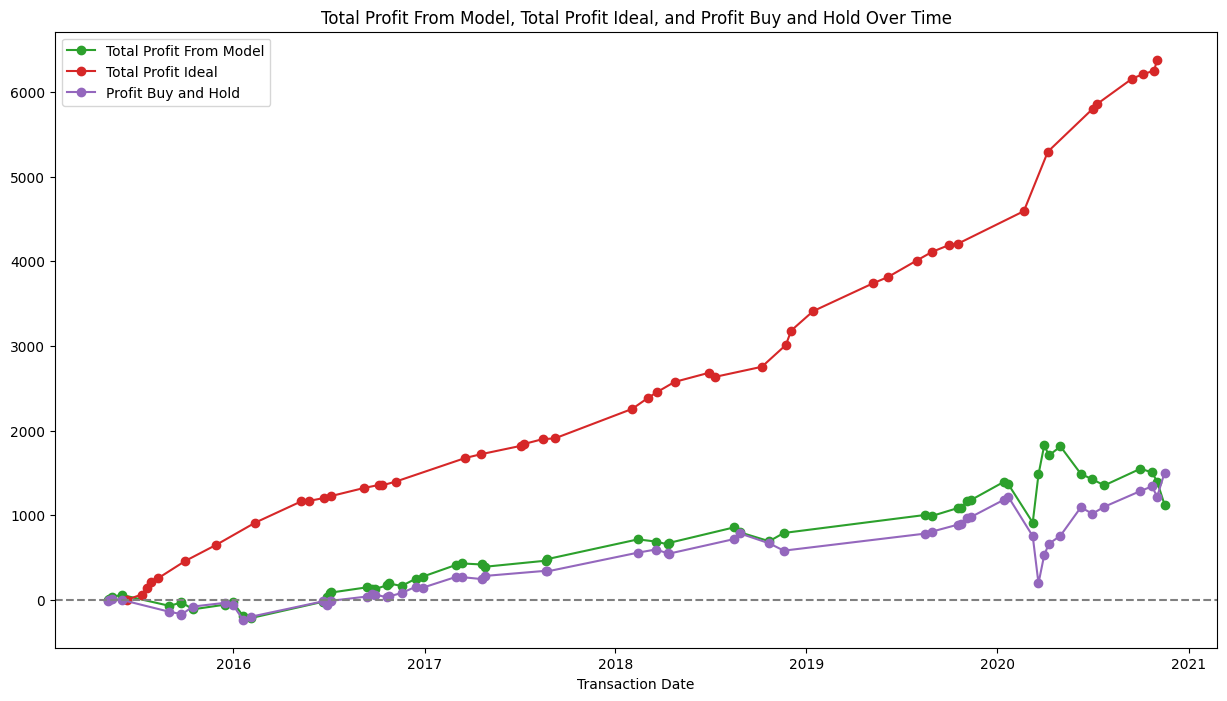

In [39]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel('Transaction Date')

# Plot total profit from the model
ax1.plot(profits_pred['Transaction Date'], profits_pred['total_profit'], color='tab:green', label='Total Profit From Model', marker='o')

# Plot total profit ideal
ax1.plot(profits_test['Transaction Date'], profits_test['total_profit'], color='tab:red', label='Total Profit Ideal', marker='o')

# Plot profit buy and hold
ax1.plot(profits_pred['Transaction Date'], profits_pred['profit_buy_and_hold'], color='tab:purple', label='Profit Buy and Hold', marker='o')

# Add legend to distinguish between the lines
ax1.legend(loc='upper left')

ax1.axhline(0, color='gray', linestyle='--')  # Adding horizontal line at y=0

# Show the plot
plt.title('Total Profit From Model, Total Profit Ideal, and Profit Buy and Hold Over Time')
plt.show()


In [40]:
stock_price_data = fetch_data(stock, stock_price_start_date, stock_price_stop_date)
# Fetching data using yfinance
ten_year_treasury_yield = yf.download("^TNX", start_date, stop_date)
# Setting datetime index for the new data
ten_year_treasury_yield.index = pd.to_datetime(ten_year_treasury_yield.index)
ten_year_treasury_yield['Daily Risk-Free Rate'] = (1 + ten_year_treasury_yield['Close'] / 100) ** (1/252) - 1
# Merge the first two dataframes on "Date"
merged_data = pd.merge(stock_price_data, ten_year_treasury_yield, on="Date", how="outer", suffixes=('', '_ten_year_yield'))
# Rename the date column in profits_pred for consistent merging
profits_pred = profits_pred.rename(columns={"Transaction Date": "Date"})
# Merge the resulting dataframe with profits_pred
merged_data = pd.merge(merged_data, profits_pred, on="Date", how="outer")
# Sort the merged dataframe by Date
merged_data = merged_data.sort_values(by="Date")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [41]:
# Initialize variables
initial_cash = 100000
cash = initial_cash
position = 0
equity = []
trade_pnls = []
is_short = False  # to track if we are in a short position

# Creating a dataframe to store trade details
trade_details = []

for idx, row in merged_data.iterrows():
    # Check for nan in 'Close' column
    if pd.isna(row['Close']):
        continue  # Skip this iteration

    equity_value = cash + position * row['Close']  # Calculate total equity

    if not pd.isna(row['Action']):
        if row['Action'] == 'Long':
            if is_short:  # if in a short position, cover it
                cover_cost = position * row['Close']
                trade_pnl = cash - cover_cost
                trade_pnls.append(trade_pnl)  # Update trade_pnls
                cash -= cover_cost
                position = 0
                is_short = False
                trade_details.append({
                    "Date": row['Date'],
                    "Action": "Cover Short",
                    "Price": row['Close'],
                    "PnL": trade_pnl,
                    "Cash": cash,
                    "Equity": equity_value,
                    "Position": position
                })
            
            position = cash / row['Close']
            cash = 0
            
            trade_details.append({
                "Date": row['Date'],
                "Action": "Enter Long",
                "Price": row['Close'],
                "PnL": None,
                "Cash": cash,
                "Equity": equity_value,
                "Position": position
            })
            
        elif row['Action'] == 'Short':
            if position:  # if in a long position, close it
                trade_pnl = cash - initial_cash  # calculate pnl for the long position
                trade_pnls.append(trade_pnl)  # Update trade_pnls
                cash += position * row['Close']
                position = 0
                trade_details.append({
                    "Date": row['Date'],
                    "Action": "Close Long",
                    "Price": row['Close'],
                    "PnL": trade_pnl,
                    "Cash": cash,
                    "Equity": equity_value,
                    "Position": position
                })
            
            position = cash / row['Close']
            cash += position * row['Close']  # adding the proceeds from the short sale
            is_short = True
            trade_details.append({
                "Date": row['Date'],
                "Action": "Enter Short",
                "Price": row['Close'],
                "PnL": None,
                "Cash": cash,
                "Equity": equity_value,
                "Position": position
            })


    # Calculate and update equity after each step
    equity_value = cash + position * row['Close'] * (1 if not is_short else -1)
    equity.append(equity_value)


# Using updated equity list to calculate metrics
equity_series = pd.Series(equity)
returns = equity_series.pct_change().dropna()

# Sharpe Ratio
returns_with_rf = returns - merged_data['Daily Risk-Free Rate'].iloc[1:] / 252
sharpe_ratio_with_rf = returns_with_rf.mean() / returns_with_rf.std() * (252**0.5)
sharpe_ratio = returns.mean() / returns.std() * (252**0.5)

# Max Drawdown
running_max = equity_series.expanding(min_periods=1).max()
drawdowns = (equity_series / running_max) - 1
max_drawdown = drawdowns.min()

# Total Return
total_return = (equity[-1] - initial_cash) / initial_cash

# Trade metrics
total_trades = len(trade_pnls)
winning_trades = len([i for i in trade_pnls if i > 0])
losing_trades = total_trades - winning_trades
avg_trade_pnl = sum(trade_pnls) / total_trades if trade_pnls else 0

metrics_manual_short_updated = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Return (%)': total_return * 100,
    'Total Trades': total_trades,
    'Winning Trades': winning_trades,
    'Losing Trades': losing_trades,
    'Average Trade PnL': avg_trade_pnl
}

metrics_manual_short_updated


{'Sharpe Ratio': -0.12576677020628824,
 'Max Drawdown': -0.36646617726099884,
 'Total Return (%)': -21.024114867646205,
 'Total Trades': 57,
 'Winning Trades': 29,
 'Losing Trades': 28,
 'Average Trade PnL': -3639.2390958626333}